### Organize Data into CSVs

In [235]:
# imports
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt

In [193]:
### Census Sales Data

df_nonadjust = pd.DataFrame()
df_label = pd.DataFrame()
xlfname = 'mrtssales92-present (1).xlsx'
xl = pd.ExcelFile(xlfname)

### Labels
df_label = xl.parse(xl.sheet_names[0], header=4, usecols='A:B',nrows = 66)
df_label = df_label.drop([0,1,2,3,4,5,6,7])
df_label = df_label.set_axis(["NAICS Code","Business Type"],axis=1)

### Not adjusted
for sheet in reversed(xl.sheet_names):
    df_tmp = pd.DataFrame()
    if sheet == '2023':
        df_tmp = xl.parse(sheet, header=4, usecols='C:K',nrows = 66)
    else:
        df_tmp = xl.parse(sheet, header=4,usecols='C:N',nrows = 66)
    df_tmp = df_tmp.drop([0,1,2,3,4,5,6,7])
    df_nonadjust = pd.concat([df_nonadjust,df_tmp], axis = 1, ignore_index=False,sort=False)

# get quartly sums for each business type

quarters = []
for i in range(len(df_nonadjust)):
    row = []
    temp_sum = 0
    m = 1
    for j in range(len(df_nonadjust.columns)):
        if df_nonadjust.iat[i,j] != '(S)' and df_nonadjust.iat[i,j] != '(NA)' :
            temp_sum+=int(df_nonadjust.iat[i,j])
        if (m % 3 == 0) or (j == len(df_nonadjust.columns)-1):
            row.append(temp_sum)
            temp_sum = 0
            m = 1
        else:
            m+=1
    quarters.append(row)

df_quarter = df_label
year = 1992
quarters = np.array(quarters)
for i in range(len(quarters[0])):
    q = (i+1) % 4
    label = ''
    if q == 0:
        label = 'Q'+str(4)+' '+str(year)
        year+=1
    else:
        label = 'Q'+str(q)+' '+str(year)
    df_quarter[label]=quarters[:,i]

Census_data = df_quarter.copy()

csvfile = 'CensusNonAdjusted.csv'
df_quarter.to_csv(csvfile, index=False)



C:\Users\CJ\AppData\Local\Temp\ipykernel_42252\3907989305.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_quarter[label]=quarters[:,i]
C:\Users\CJ\AppData\Local\Temp\ipykernel_42252\3907989305.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df_quarter[label]=quarters[:,i]
C:\Users\CJ\AppData\Local\Temp\ipykernel_42252\3907989305.py:52: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once

In [100]:
### GDP 

df = pd.read_csv('GDP raw.csv',parse_dates=['DATE'])

quarters = []
for d in df.DATE:
    q = (int(d.month)-1)/3+1
    label = "Q"+str(int(q))+" "+ str(d.year)
    quarters.append(label)

df['Quarter'] = quarters

csvfile = 'GDP.csv'
df.to_csv(csvfile, index=False)

GDP_Data = df


In [217]:
### Zillow Housing Price Data

df = pd.read_csv('Zillow_Raw.csv',parse_dates=['DATE'])
data = pd.DataFrame(zip(df.DATE, df.ZHVI),
               columns =['Date','ZHVI'])


quarters = []
labels = []
m = 1
q = 1
temp_sum = 0
for i in range(len(data.Date)):
    temp_sum+=int(data.ZHVI.iat[i])
    if (m % 3 == 0) or (i == len(data.Date)-1):
        quarters.append(temp_sum/3.0)
        labels.append('Q'+str(q)+' '+str(data.Date.iat[i].year))
        temp_sum = 0
        m = 1
        q+=1
    else:
        m+=1

    if q == 5:
        q = 1


new_data = pd.DataFrame()
new_data['Quarter'] = labels
new_data['ZHVI'] = quarters

csvfile = 'Zillow.csv'
new_data.to_csv(csvfile, index=False)

Zillow_Data = new_data



In [214]:
### Coffee Production Data

df = pd.read_csv('Coffee_production.csv', parse_dates=['DATE'])

quarters = []
for d in df.DATE:
    q = (int(d.month)-1)/3+1
    label = "Q"+str(int(q))+" "+ str(d.year)
    quarters.append(label)

df['Quarter'] = quarters
df = df.set_axis(["Date","PI","Quarter"],axis=1)

csvfile = 'Coffee.csv'
df.to_csv(csvfile, index=False) 

Coffee_Data = df

### Normalize Data

In [232]:
# explicit function to normalize array
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)    
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

def quarter_to_num(columns):
    tmp = []
    for i in range(len(columns)):
        q_y = [int(columns[i][1]),int(columns[i][3:])]
        tmp.append(q_y)
    return np.array(tmp)
    

Census_data = df_quarter.copy()
c = len(Census_data.columns)
r = len(Census_data)

census_y = []
census_names = []
census_x = quarter_to_num(Census_data.columns[2:])
# Census
for i in range(r):
    row = Census_data.iloc[i]
    n_row = normalize(row[2:], 0 , 1)
    census_y.append(n_row)
    census_names.append(row[1])
    for j in range(2,c):
        Census_data.at[i,Census_data.columns[j]] = n_row[j-2]
census_y = np.array(census_y)

# GDP
GDP_Data.GDPC1 = normalize(GDP_Data.GDPC1, 0 , 1)
GDP_x = quarter_to_num(GDP_Data.Quarter)
GDP_y = np.array(GDP_Data.GDPC1)

# Zillow
Zillow_Data.ZHVI = normalize(Zillow_Data.ZHVI, 0 , 1)
Zillow_x = quarter_to_num(Zillow_Data.Quarter)
Zillow_y = np.array(Zillow_Data.ZHVI)

# Coffee
Coffee_Data.PI = normalize(Coffee_Data.PI, 0 , 1)
Coffee_x = quarter_to_num(Coffee_Data.Quarter)
Coffee_y = np.array(Coffee_data.PI)



C:\Users\CJ\AppData\Local\Temp\ipykernel_42252\1680129568.py:31: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  census_names.append(row[1])


In [233]:
# get x an y for each to be used in regression

# Census
# census_y consists of rows of all the sales for different categories
# census_names consists of all the names of categories, same indices as their corresponding values 
# census_x contains a list of years and corresponding quarters
census_x_interval = census_x[:,1]+census_x[:,0]/4.0 # this contains years plus quarter/4 to create incremented x values

# GDP
# GDP_y consists of all GDP values
# GDP_x consists of a list of years and corresponding quarters
GDP_x_interval = GDP_x[:,1]+GDP_x[:,0]/4.0

# Zillow
# Zillow_y consists of all house index values
# Zillow_x consists of a list of years and corresponding quarters
Zillow_x_interval = Zillow_x[:,1]+Zillow_x[:,0]/4.0

# Coffee
# Coffee_y consists of all producer indexes 
# Coffee_x consists of a list of years and corresponding quarters
Coffee_x_interval = Coffee_x[:,1]+Coffee_x[:,0]/4.0

### Initial Regression Models

### Polynomial Regression

Motor vehicle and parts dealers
Coefficients are:
[-7.59272327e+03 -1.79077387e+01  1.19011621e-02 -1.52475099e-06
  2.15873607e-09  9.57058719e-13 -7.26258428e-16  1.11267603e-19
 -1.63866683e-22 -5.95514076e-26  4.64010460e-29]
For x = 2023.5, y is 0.9933157506675343 and the expected is 1.0
For x = 2023.75, y is 1.0192041951886495 and the expected is 0.9852962721670309
MSE =  0.0002986066083423187


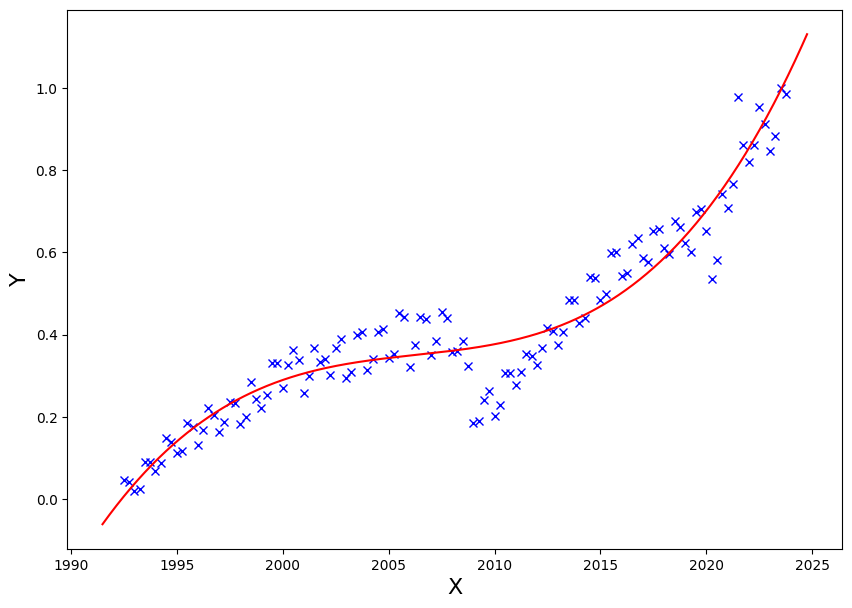

Automobile and other motor vehicle dealers
Coefficients are:
[-9.19329402e+03 -1.77293652e+01  1.22053853e-02 -1.32503769e-06
  2.20401378e-09  9.10042050e-13 -7.31022687e-16  1.08307203e-19
 -1.70443017e-22 -5.80366964e-26  4.71834407e-29]
For x = 2023.5, y is 1.0061393867072184 and the expected is 1.0
For x = 2023.75, y is 1.032922517231782 and the expected is 0.9827136289886426
MSE =  0.0006396561321208667


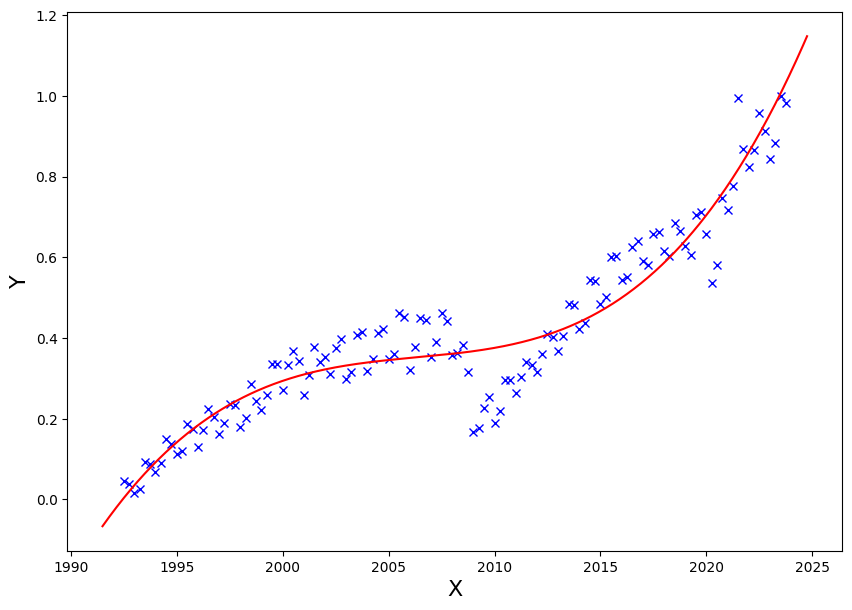

Automobile dealers
Coefficients are:
[-1.46107333e+04 -1.29040978e+01  1.08774611e-02 -8.81534010e-08
  1.92077953e-09  4.84285976e-13 -5.88661581e-16  6.97781611e-20
 -1.62893372e-22 -3.78315046e-26  4.02325710e-29]
For x = 2023.5, y is 1.016240014010691 and the expected is 1.0
For x = 2023.75, y is 1.043020591547247 and the expected is 0.9966497909858438
MSE =  0.0006034972999179511


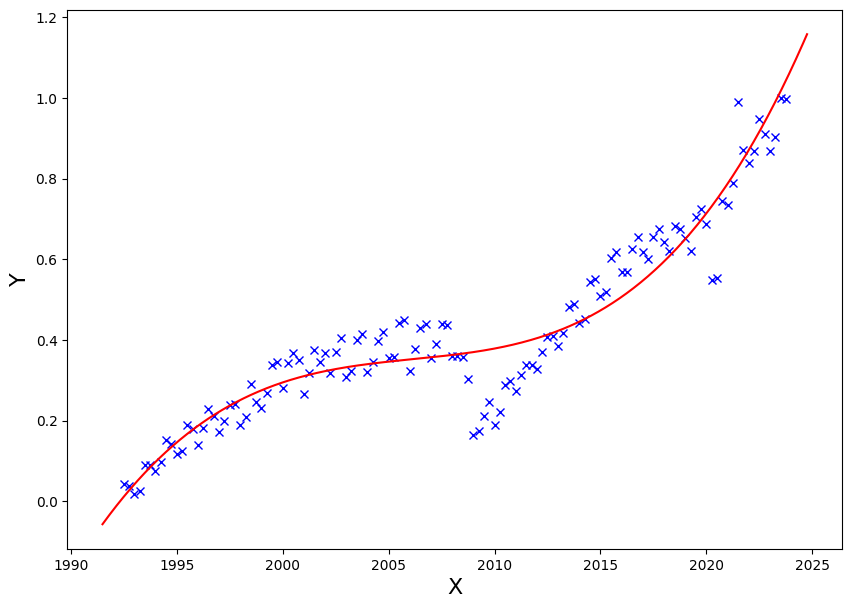

New car dealers
Coefficients are:
[-1.92363821e+04 -9.90983334e+00  1.03702507e-02  8.17881226e-07
  1.79523033e-09  1.92097778e-13 -5.09204063e-16  4.45205982e-20
 -1.64367180e-22 -2.46128202e-26  3.68473401e-29]
For x = 2023.5, y is 1.021282826193783 and the expected is 0.996054959697678
For x = 2023.75, y is 1.0483433421468362 and the expected is 1.0
MSE =  0.0007433809940702086


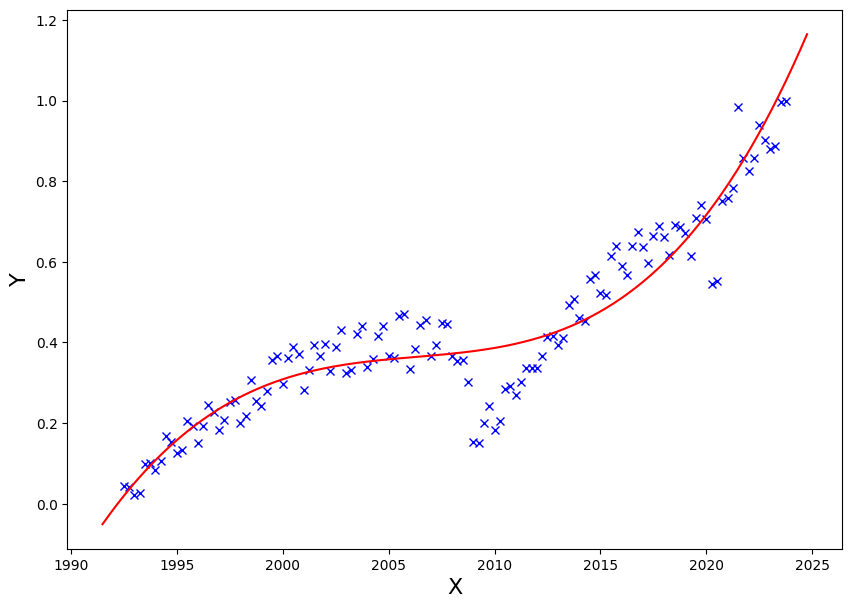

Used car dealers
Coefficients are:
[-1.59347050e+04  1.88814211e+00  4.62524218e-03 -4.08984491e-06
  2.53903048e-09  1.36687403e-12 -9.90004733e-16  2.55473092e-19
 -7.83965355e-23 -1.18389682e-25  5.21062006e-29]
For x = 2023.5, y is 0.9618597278822563 and the expected is 1.0
For x = 2023.75, y is 0.985813655621314 and the expected is 0.9549867387279187
MSE =  0.0006012447909255399


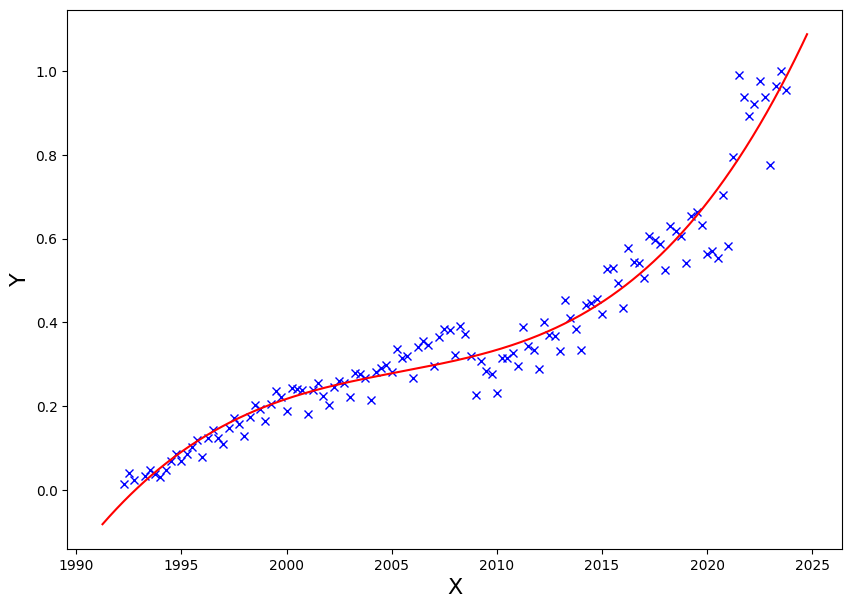

Automotive parts, acc., and tire stores
Coefficients are:
[ 1.11986067e+04 -1.97092577e+01  8.16611107e-03 -3.83048502e-06
  1.59666223e-09  1.49058107e-12 -6.59328585e-16  1.44066476e-19
 -8.45821541e-23 -7.62913789e-26  3.65479749e-29]
For x = 2023.5, y is 0.8281702147432952 and the expected is 0.9843454258675078
For x = 2023.75, y is 0.8432163242687238 and the expected is 1.0
MSE =  0.012242954385802994


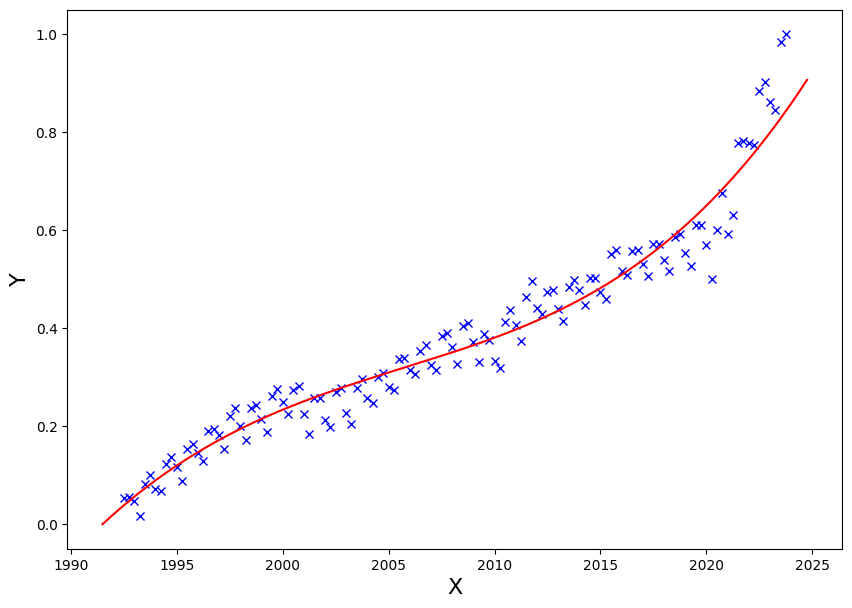

Furniture, home furn, electronics, and appliance stores
Coefficients are:
[ 2.74642957e+04 -4.86201886e+01  2.01359089e-02 -9.47077826e-06
  3.93774800e-09  3.68612788e-12 -1.62298302e-15  3.57935170e-19
 -2.08297802e-22 -1.88785095e-25  8.99185077e-29]
For x = 2023.5, y is 0.8778354686946841 and the expected is 0.76340489025799
For x = 2023.75, y is 0.8918057198025053 and the expected is 0.7929582210242587
MSE =  0.005716296323961276


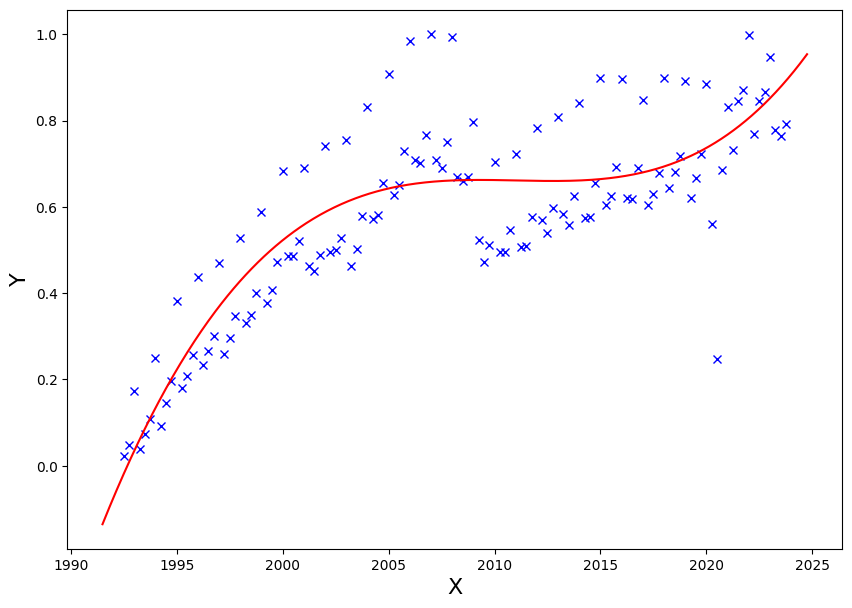

Furniture and home furnishings stores
Coefficients are:
[ 2.83196041e+04 -5.69816642e+01  2.46333637e-02 -1.06693177e-05
  4.76923254e-09  4.22934973e-12 -1.93403062e-15  4.14802952e-19
 -2.63664594e-22 -2.18918997e-25  1.08482572e-28]
For x = 2023.5, y is 1.0348667416837998 and the expected is 0.8484016083442812
For x = 2023.75, y is 1.0621272471471457 and the expected is 0.8515864485051157
MSE =  0.019774168461037064


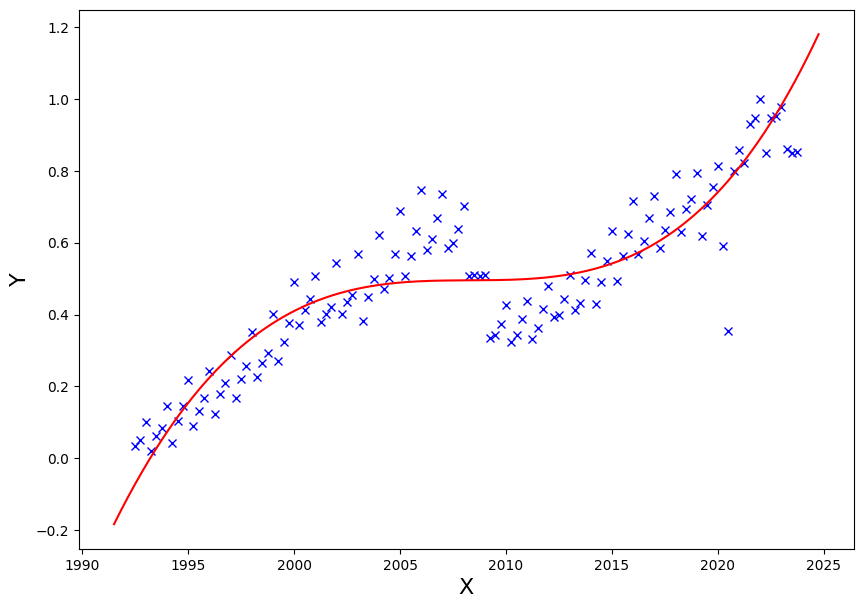

Furniture stores
Coefficients are:
[ 3.38772680e+04 -6.55457273e+01  2.80179540e-02 -1.24091423e-05
  5.43558096e-09  4.89180117e-12 -2.21632522e-15  4.78098435e-19
 -2.97143012e-22 -2.52417398e-25  1.23890125e-28]
For x = 2023.5, y is 1.0642657857679296 and the expected is 0.8552682362022385
For x = 2023.75, y is 1.0965194453601725 and the expected is 0.9135468930914705
MSE =  0.019289732645011392


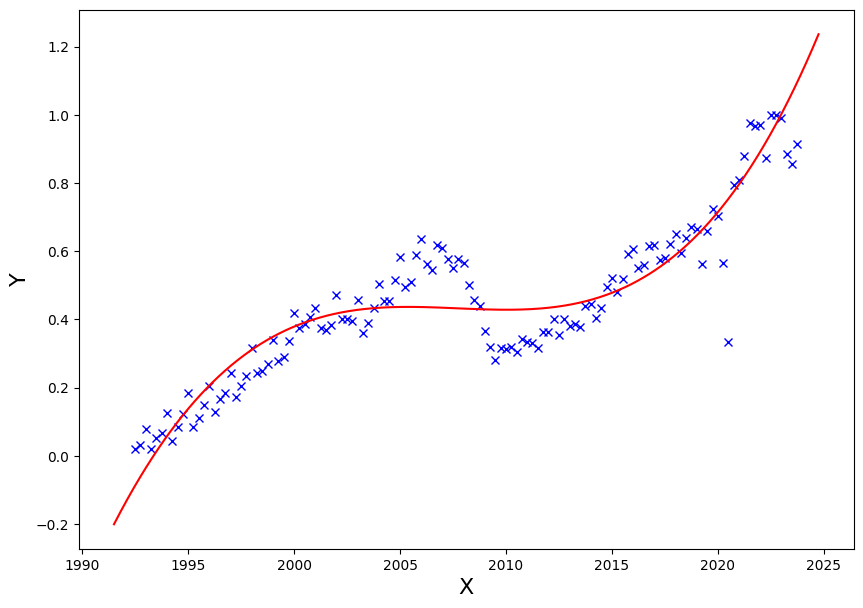

Home furnishings stores
Coefficients are:
[ 1.22774711e+04 -1.93928888e+01 -4.90451404e-03  2.01934176e-06
  3.51384873e-09  1.01151799e-12 -7.72336004e-16  6.63264015e-19
 -3.24411274e-22 -2.34246782e-25  1.06345165e-28]
For x = 2020.5, y is 0.9542625355970813 and the expected is 0.5666624621594349
For x = 2020.75, y is 0.969204354507383 and the expected is 0.8983980827447023
MSE =  0.03881183626193468


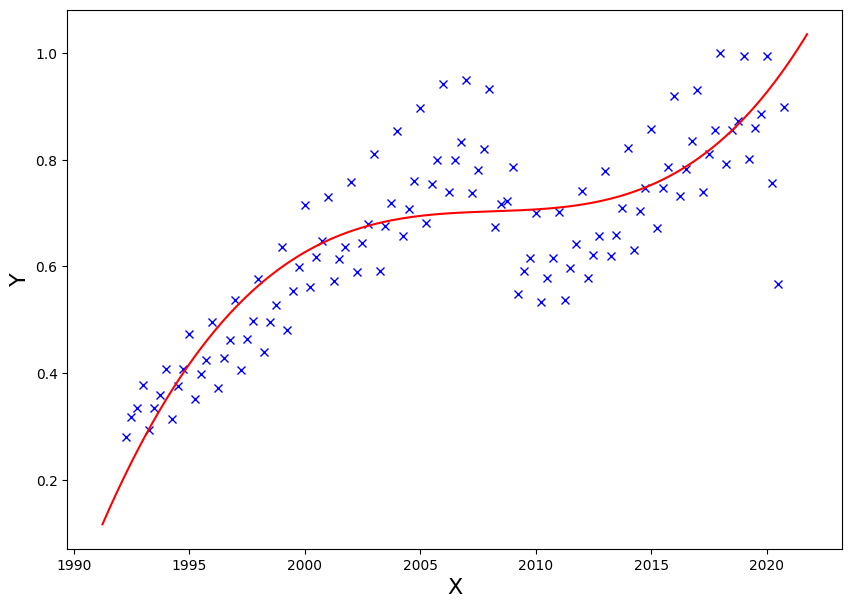

Floor covering stores
Coefficients are:
[-3.74988406e+04  1.61471611e+01  5.02205166e-03 -4.67410006e-06
 -1.91836796e-09  2.74612214e-12  1.06525266e-15  1.85718046e-19
 -6.54686739e-22 -1.53682210e-25  1.16860243e-28]
For x = 2017.0, y is 0.7632258548110258 and the expected is 0.8565096043342637
For x = 2017.25, y is 0.7705208286643028 and the expected is 0.48826136923329505
MSE =  0.022093065088099776


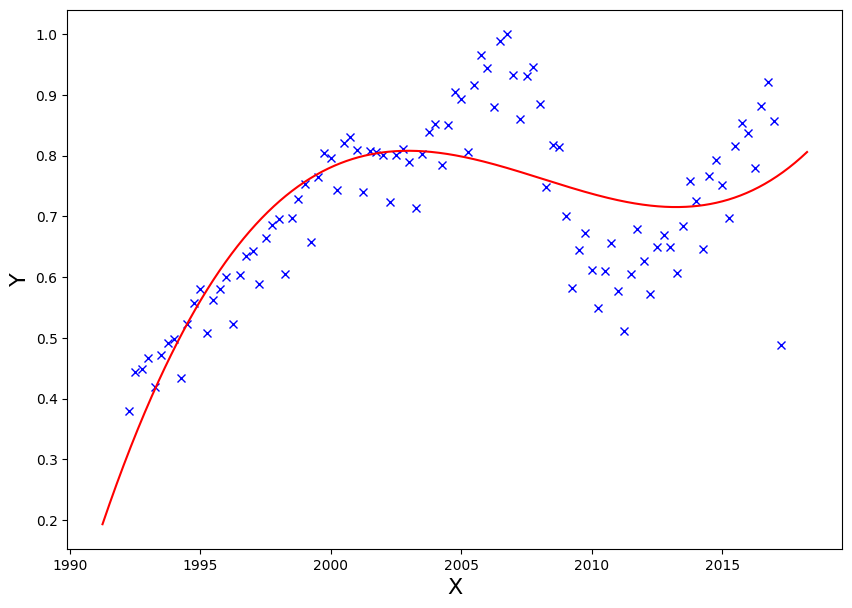

All other home furnishings stores
Coefficients are:
[-8.55683762e+04  5.59719527e+01 -2.98599890e-02  1.58244902e-05
  5.12094215e-09 -5.64647453e-13 -1.82353593e-15  1.33728082e-19
  2.96809351e-22 -4.30399957e-25  1.43137982e-28]
For x = 2020.5, y is 0.9372764911095146 and the expected is 0.3769483617856007
For x = 2020.75, y is 0.9577847269829363 and the expected is 0.7647121196055562
MSE =  0.08781116106734474


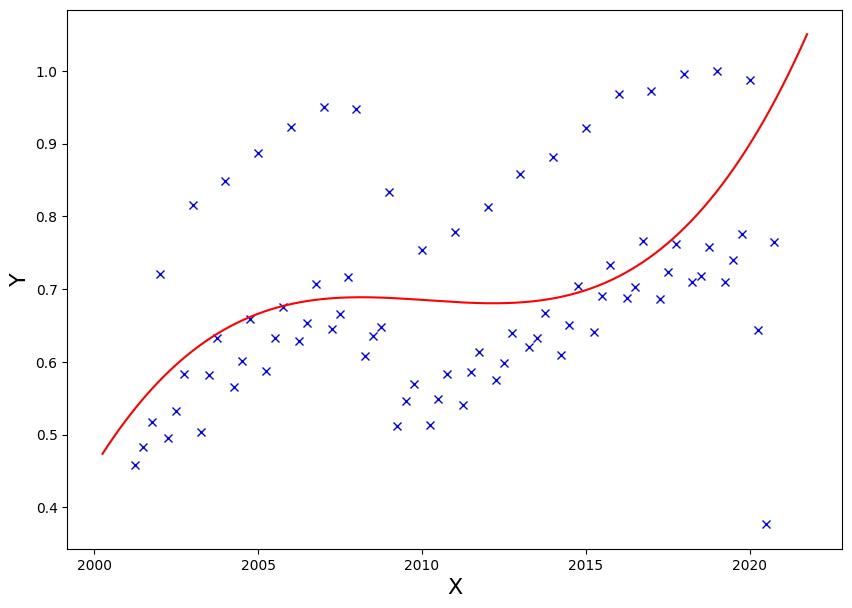

Electronics and appliance stores
Coefficients are:
[ 1.81872197e+04 -2.49193590e+01  9.22068941e-03 -5.31128613e-06
  1.85422918e-09  1.98565643e-12 -7.97892338e-16  1.88438307e-19
 -8.59859587e-23 -9.92377916e-26  4.27910168e-29]
For x = 2023.5, y is 0.44347134313284187 and the expected is 0.4404671236354405
For x = 2023.75, y is 0.4390597005331074 and the expected is 0.48904121181348903
MSE =  0.0006267942013412381


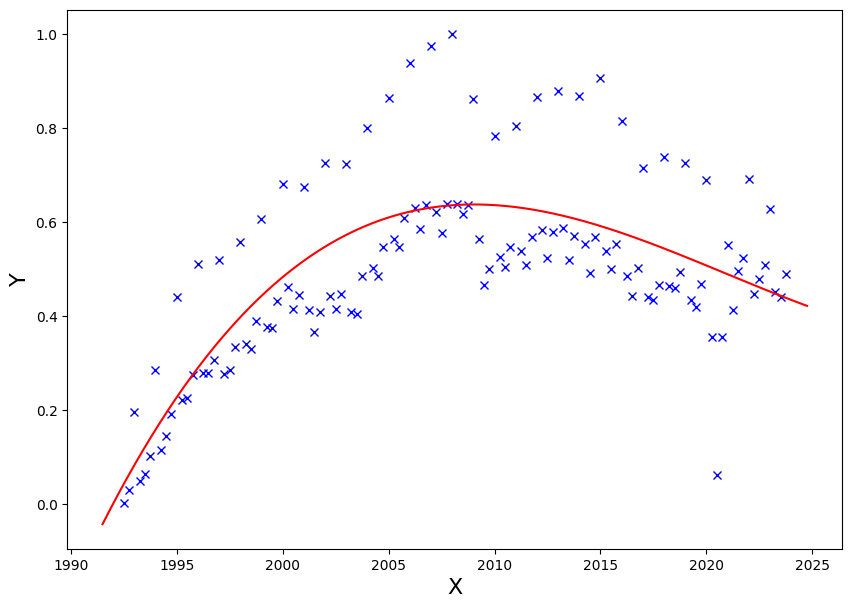

Household appliance stores
Coefficients are:
[ 5.59612607e+04 -5.99704918e+01  1.93301026e-02 -1.41188490e-05
  3.97462959e-09  5.03868065e-12 -1.84803952e-15  4.66188712e-19
 -1.49207139e-22 -2.44922479e-25  9.47054367e-29]
For x = 2023.5, y is 0.8936919774860144 and the expected is 0.8325
For x = 2023.75, y is 0.9037433515768498 and the expected is 0.8705555555555555
MSE =  0.001211471978591454


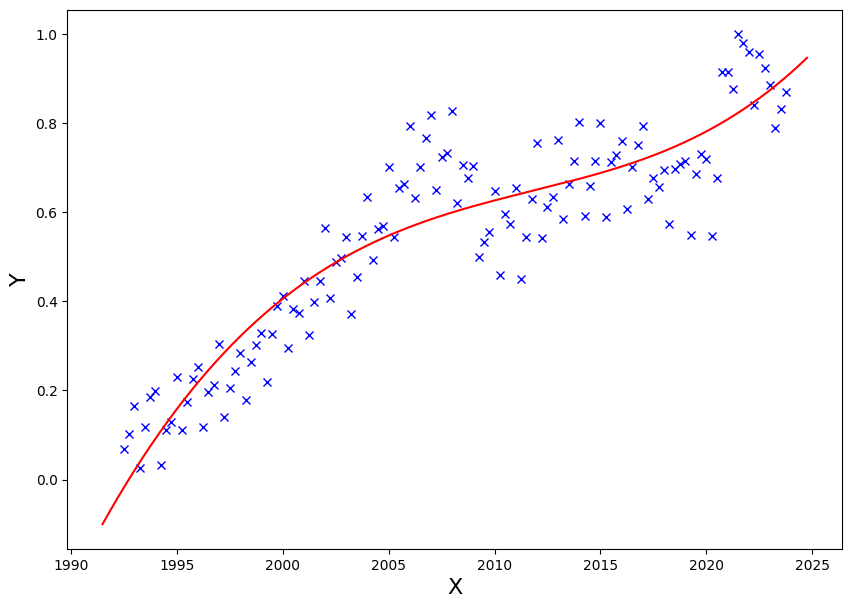

Electronics stores
Coefficients are:
[-3.36629532e+04  2.50928527e+01 -8.37904795e-04 -2.35997093e-06
  1.63790919e-09 -5.44167307e-13 -7.52911862e-17 -2.35375535e-20
  3.13513853e-23 -2.74128126e-26  1.05048018e-29]
For x = 2023.5, y is 0.5535045586202614 and the expected is 0.5535666127292341
For x = 2023.75, y is 0.5495104458714195 and the expected is 0.5876483279395901
MSE =  0.00036362547480476133


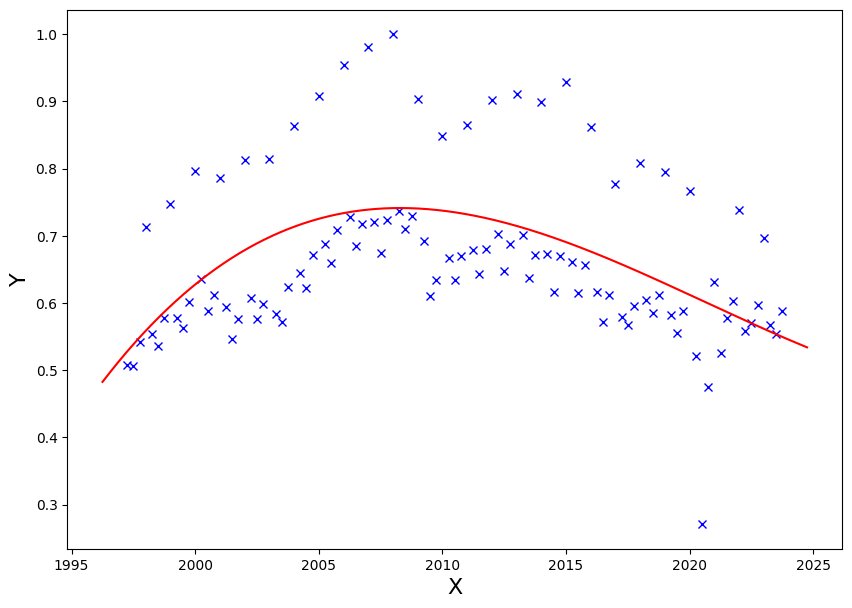

Building mat. and garden equip. and supplies dealers
Coefficients are:
[ 4.01193246e+04 -5.66214478e+01  2.14827949e-02 -1.19155161e-05
  4.26240980e-09  4.46784857e-12 -1.83803526e-15  4.25041698e-19
 -2.03654594e-22 -2.23988420e-25  9.90172340e-29]
For x = 2023.5, y is 0.8899284506915137 and the expected is 0.962145864828623
For x = 2023.75, y is 0.9132262558559887 and the expected is 0.8386757885566403
MSE =  0.0026932817692580666


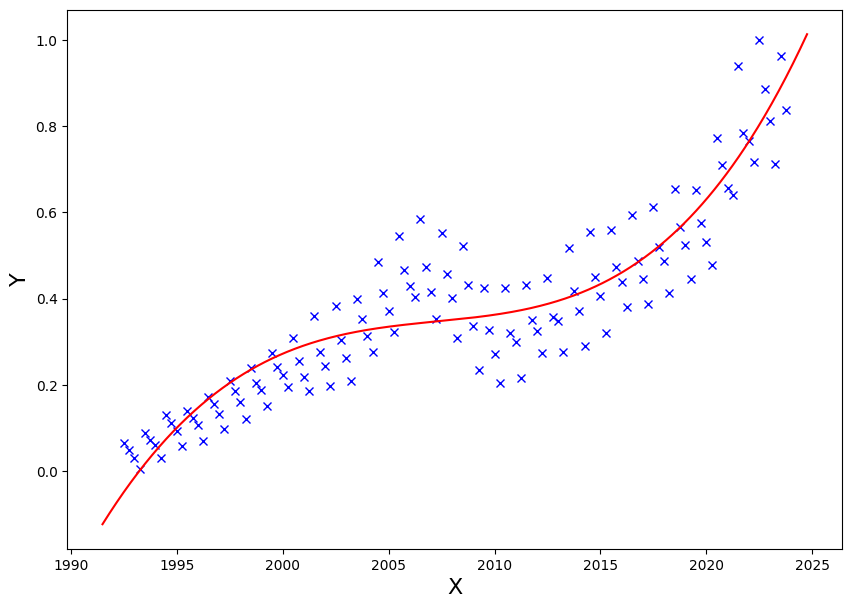

Building mat. and supplies dealers
Coefficients are:
[ 4.27796830e+04 -5.96292260e+01  2.24907210e-02 -1.26086884e-05
  4.46732291e-09  4.71750431e-12 -1.93183949e-15  4.48334404e-19
 -2.11847009e-22 -2.36204258e-25  1.03875695e-28]
For x = 2023.5, y is 0.9097671739436919 and the expected is 0.9427791021056814
For x = 2023.75, y is 0.9334245856443886 and the expected is 0.858482320222487
MSE =  0.0016765326358591096


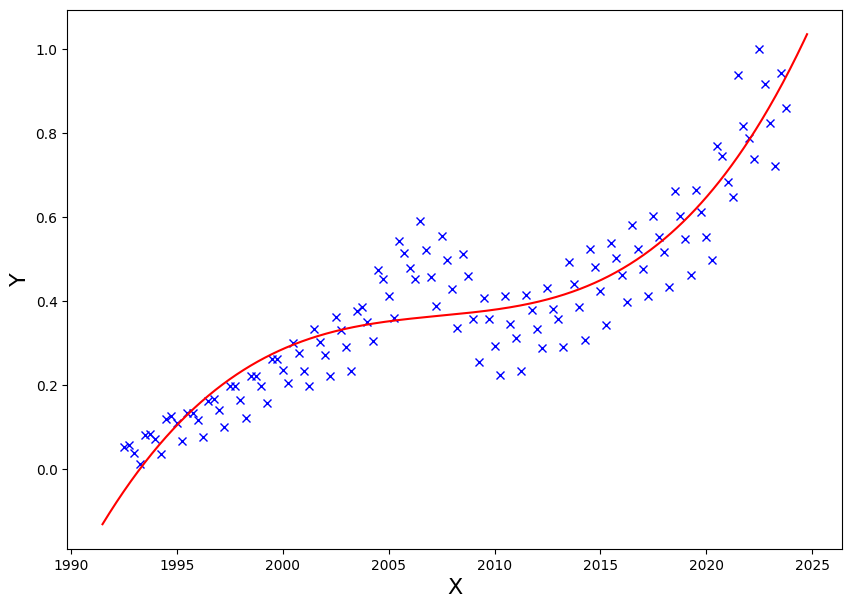

Paint and wallpaper stores
Coefficients are:
[ 1.23969373e+05 -1.01708497e+02  5.21498327e-03 -4.86026571e-05
  3.05951252e-08  1.97796929e-11 -7.95723808e-15 -2.82745364e-18
 -8.44608974e-22  1.17039539e-24 -1.82527395e-28]
For x = 2023.5, y is 0.9350760674860794 and the expected is 1.0
For x = 2023.75, y is 0.9576441487297416 and the expected is 0.9839349050698936
MSE =  0.0012265802205023394


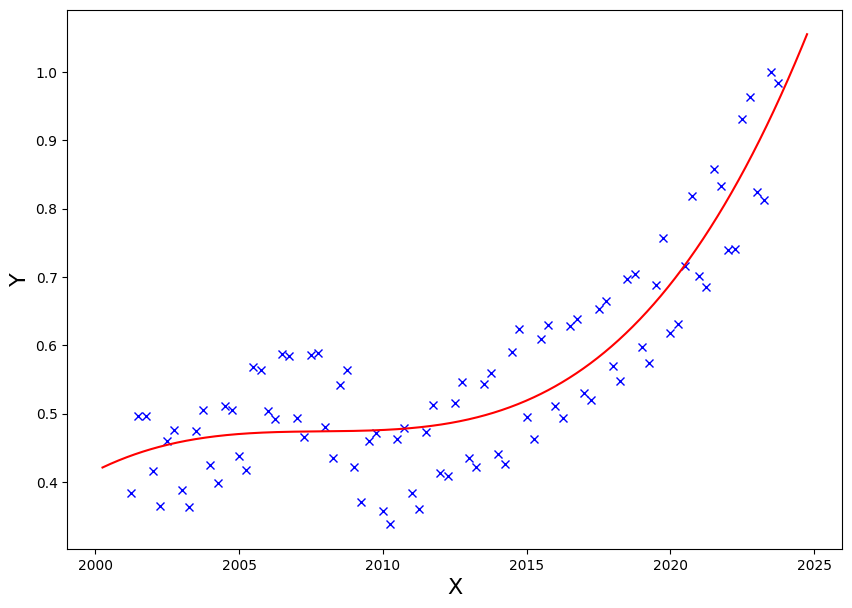

Hardware stores
Coefficients are:
[ 2.74709604e+04 -3.94876766e+01  1.51407328e-02 -8.24567968e-06
  2.99415024e-09  3.10079309e-12 -1.28785595e-15  2.95248415e-19
 -1.44935226e-22 -1.55738883e-25  6.95781280e-29]
For x = 2023.5, y is 0.8876832172827562 and the expected is 1.0
For x = 2023.75, y is 0.9115402341994923 and the expected is 0.8985028881291995
MSE =  0.0031962580184410287


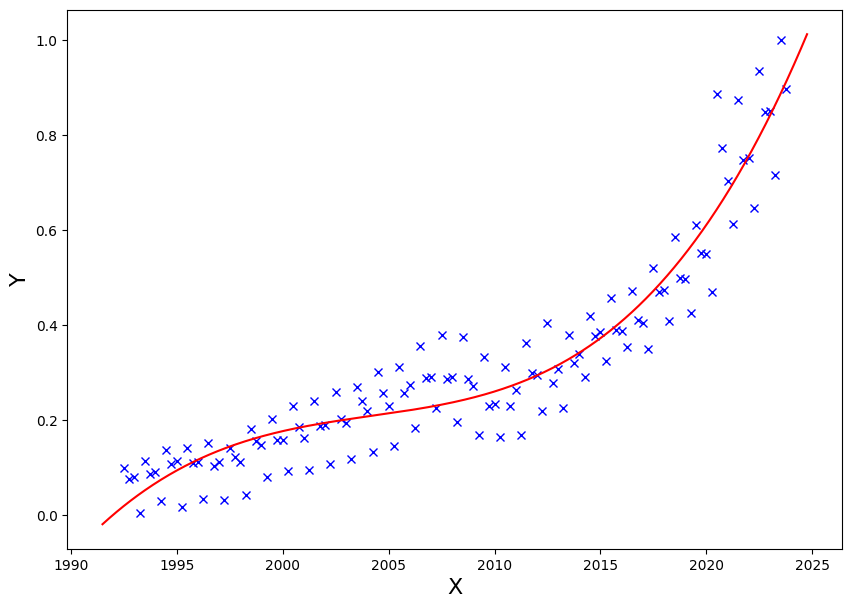

Food and beverage stores
Coefficients are:
[ 1.93891248e+04 -2.33035883e+01  8.14233181e-03 -5.21128708e-06
  1.64109909e-09  1.89929126e-12 -7.38020973e-16  1.77423653e-19
 -7.01251906e-23 -9.35648511e-26  3.87545124e-29]
For x = 2023.5, y is 0.9271947689630906 and the expected is 0.9479829766828508
For x = 2023.75, y is 0.9451337088466971 and the expected is 0.9596415512797458
MSE =  0.0001606567680462104


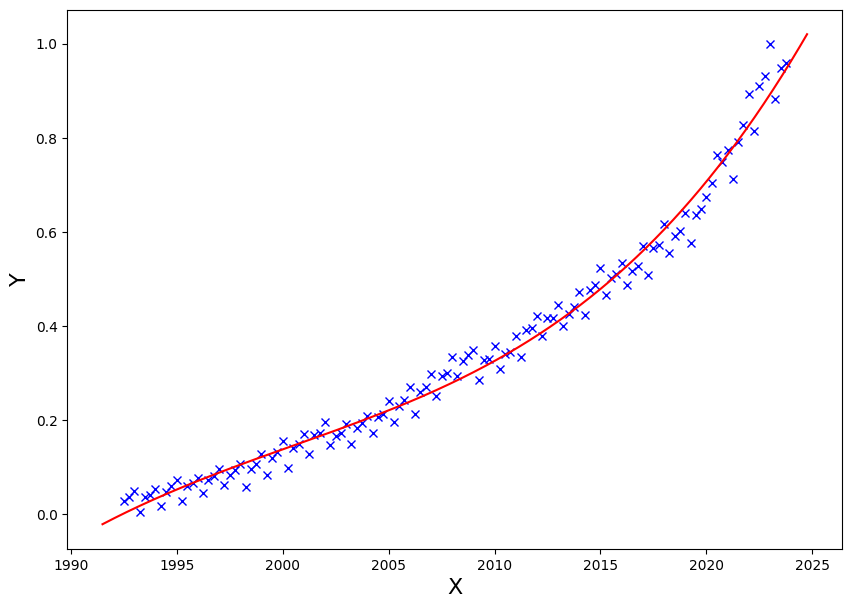

Grocery stores
Coefficients are:
[ 1.90256476e+04 -2.32564499e+01  8.20773926e-03 -5.16426393e-06
  1.65086173e-09  1.88799597e-12 -7.38879844e-16  1.76654783e-19
 -7.15867346e-23 -9.31863502e-26  3.89208939e-29]
For x = 2023.5, y is 0.9315784282589448 and the expected is 0.9596323624949566
For x = 2023.75, y is 0.949905602967192 and the expected is 0.9716134061861028
MSE =  0.0003145629866311848


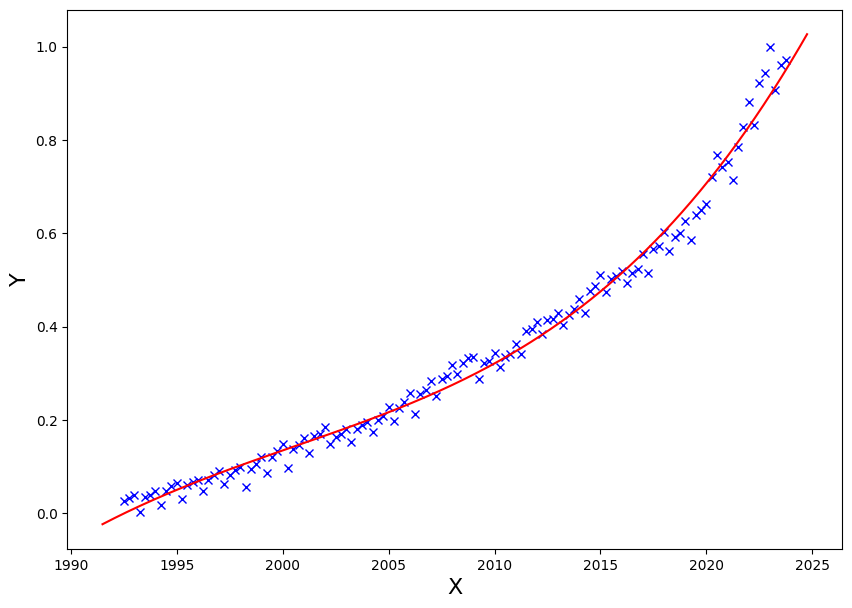

Supermarkets and other grocery (except convenience) stores
Coefficients are:
[ 7.11194034e+04 -5.77827366e+01  2.84950479e-03 -2.77599181e-05
  1.76547089e-08  1.11803614e-11 -4.70151855e-15 -1.55235385e-18
 -4.48692459e-22  6.60026506e-25 -1.06043877e-28]
For x = 2023.5, y is 0.9750320209277561 and the expected is 0.9722923190274452
For x = 2023.75, y is 0.9896357352845371 and the expected is 0.9795910849143489
MSE =  2.7100242036641216e-05


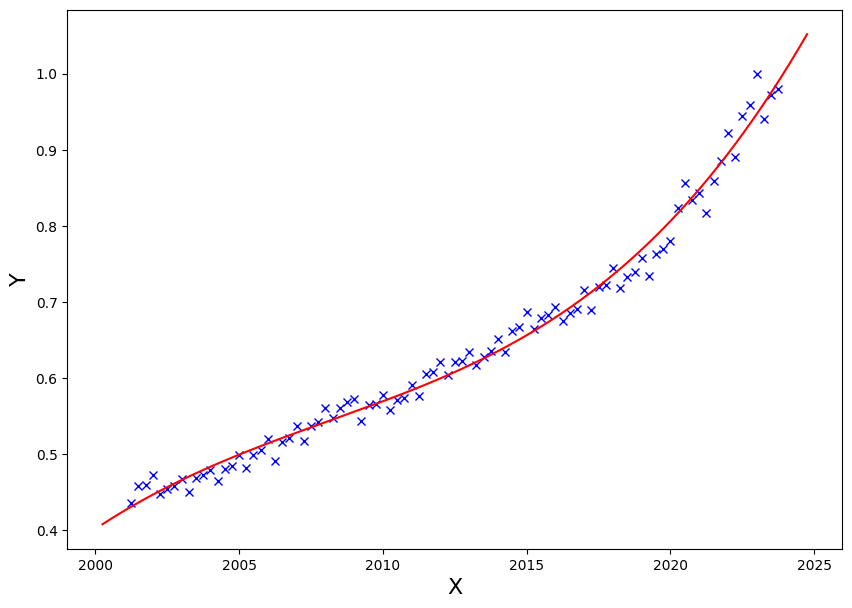

Beer, wine, and liquor stores
Coefficients are:
[ 2.23361302e+04 -2.51307631e+01  8.42146420e-03 -5.78130604e-06
  1.71199739e-09  2.08119892e-12 -7.85586619e-16  1.93203934e-19
 -6.85618501e-23 -1.01744576e-25  4.07151477e-29]
For x = 2023.5, y is 0.9209826663136482 and the expected is 0.8804965007262644
For x = 2023.75, y is 0.9379734657413792 and the expected is 0.8852502310841146
MSE =  0.0011047172696307679


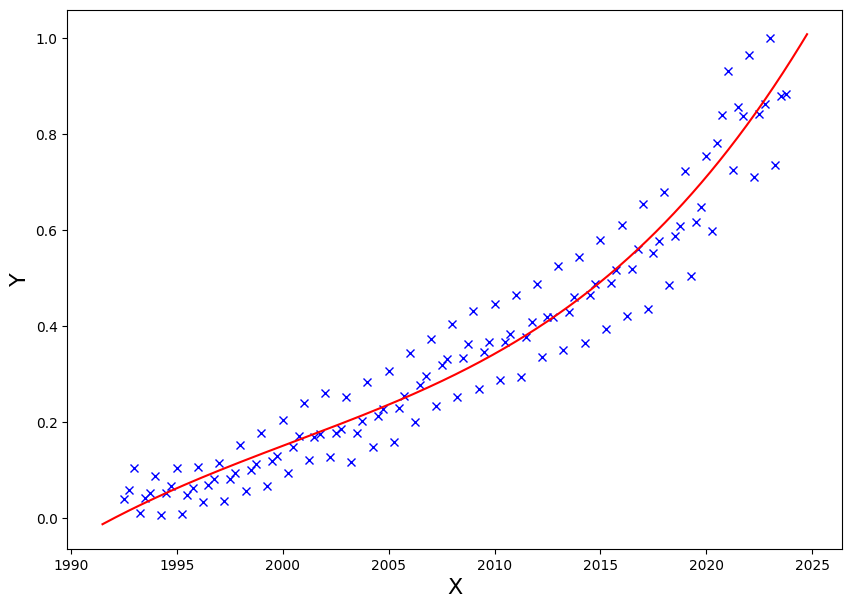

Health and personal care stores
Coefficients are:
[ 2.50766173e+05 -2.21081924e+02  1.72620501e-02  1.56019092e-06
  2.05639148e-09  8.32126036e-12 -2.95785055e-15  1.32823331e-18
 -3.65280488e-22 -5.12937383e-25  1.81747908e-28]
For x = 2023.5, y is 0.9191236309707165 and the expected is 0.9969702266503525
For x = 2023.75, y is 0.9291202952153981 and the expected is 1.0
MSE =  0.002771006255713713


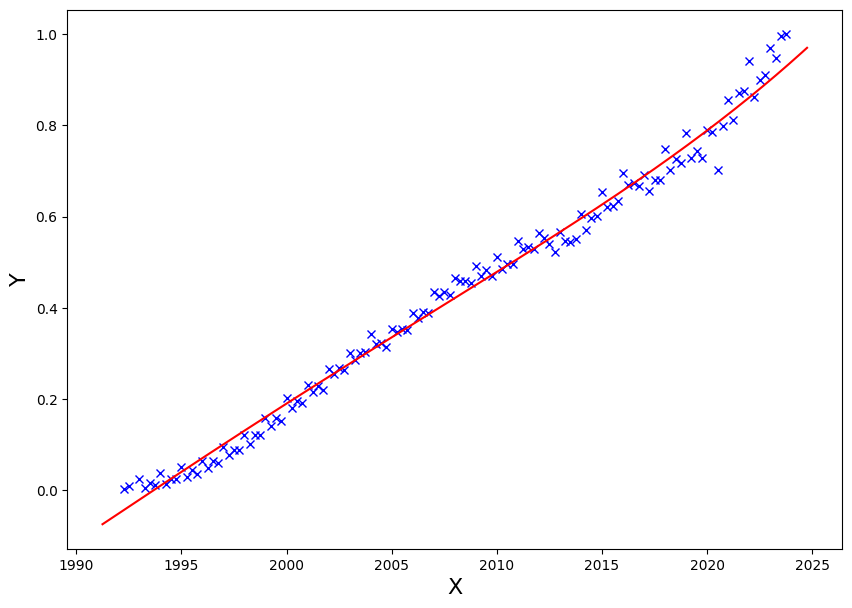

Pharmacies and drug stores
Coefficients are:
[ 3.10423506e+05 -2.73381374e+02  2.12475444e-02  1.90706047e-06
  2.52988170e-09  1.02910970e-11 -3.65384364e-15  1.64362926e-18
 -4.50263710e-22 -6.34423514e-25  2.24466173e-28]
For x = 2023.5, y is 0.9167544236697722 and the expected is 0.9915056394678368
For x = 2023.75, y is 0.9266213974624407 and the expected is 1.0
MSE =  0.002743040892345682


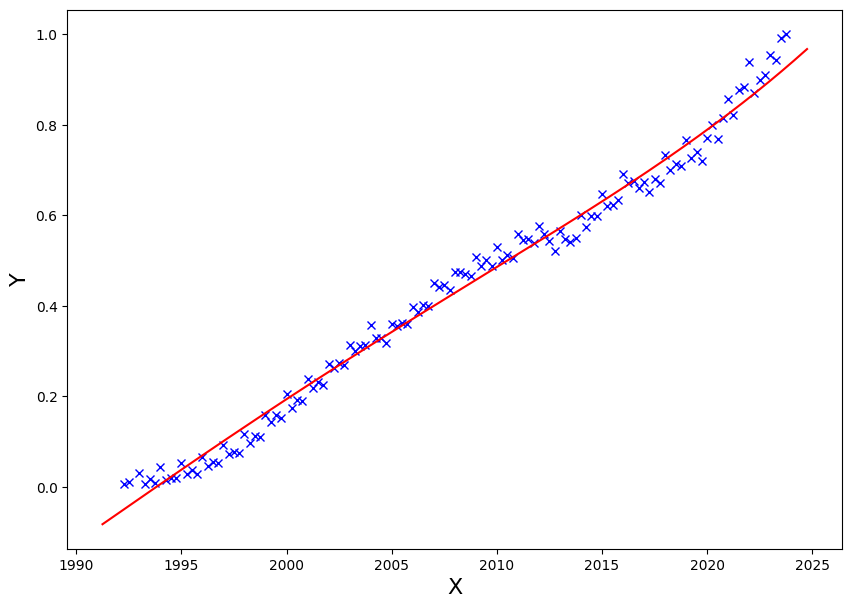

Gasoline stations
Coefficients are:
[ 5.88015427e+04 -4.25831717e+01  8.92965398e-03 -1.21153747e-05
  2.06405784e-09  4.00127088e-12 -1.17689216e-15  3.51504090e-19
 -1.28385936e-23 -1.84241705e-25  5.31745648e-29]
For x = 2023.5, y is 0.6137463890336221 and the expected is 0.7606365646456418
For x = 2023.75, y is 0.6134878532247967 and the expected is 0.815239148143838
MSE =  0.015570077174343123


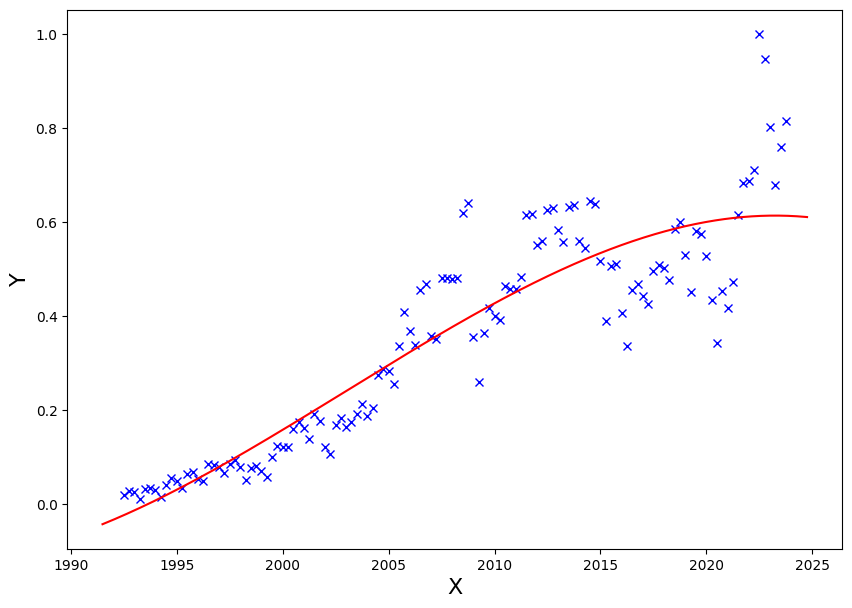

Clothing and clothing access. stores
Coefficients are:
[ 2.00926971e+04 -1.66064373e+01  4.19251412e-03 -4.41163472e-06
  9.18150542e-10  1.49702259e-12 -4.78913399e-16  1.33908662e-19
 -1.88639248e-23 -7.02900921e-26  2.28282783e-29]
For x = 2023.5, y is 0.6946274901820289 and the expected is 0.754909204580977
For x = 2023.75, y is 0.698787041605101 and the expected is 0.7603370371422887
MSE =  0.001855571760488005


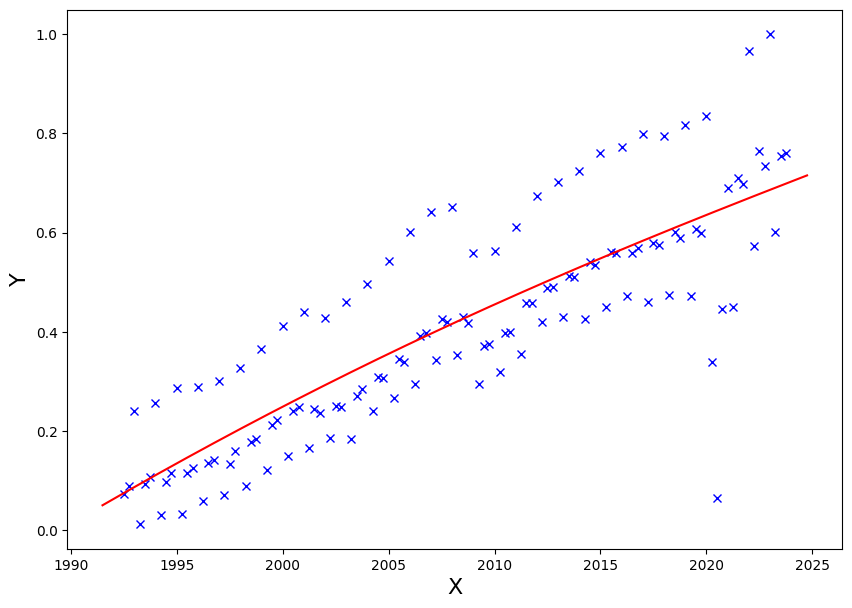

Clothing stores
Coefficients are:
[ 2.06085700e+04 -1.27004805e+01  1.88176607e-03 -3.95515853e-06
  4.92371082e-10  1.26328058e-12 -3.28450835e-16  1.08489499e-19
  1.13474850e-23 -5.66995038e-26  1.35383935e-29]
For x = 2023.5, y is 0.6628468368289759 and the expected is 0.7814792543595911
For x = 2023.75, y is 0.6629442816429219 and the expected is 0.7929845660452997
MSE =  0.0077460315143785445


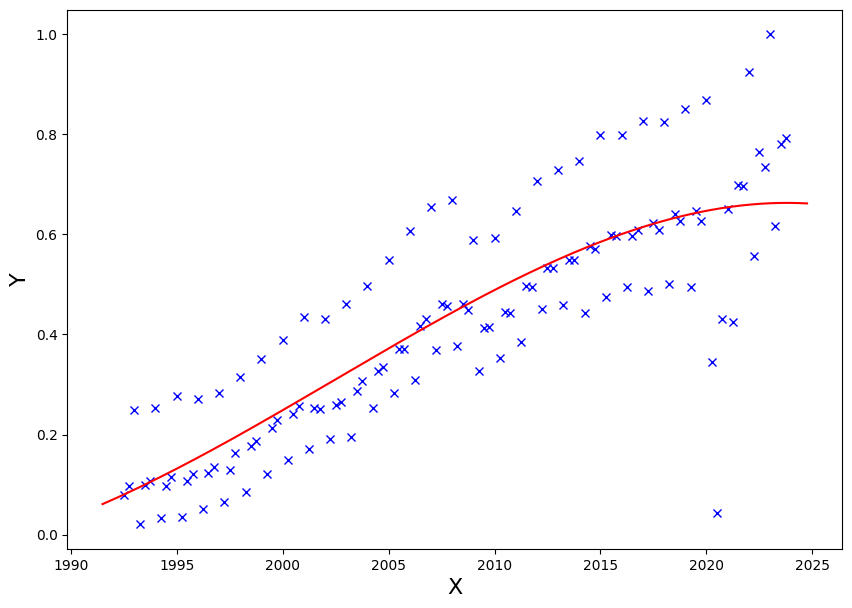

Men's clothing stores
Coefficients are:
[-1.55797020e+03  5.65778429e+00 -1.74964790e-02  1.52475023e-05
  2.34984892e-10 -4.00709215e-12  8.34779347e-16  6.69291767e-20
 -2.22969545e-22  2.20941373e-25 -5.40219014e-29]
For x = 2021.25, y is 0.6265212048601825 and the expected is 0.4030475052285629
For x = 2021.5, y is 0.6255385782133089 and the expected is 0.20764864057364804
MSE =  0.05614312360014554


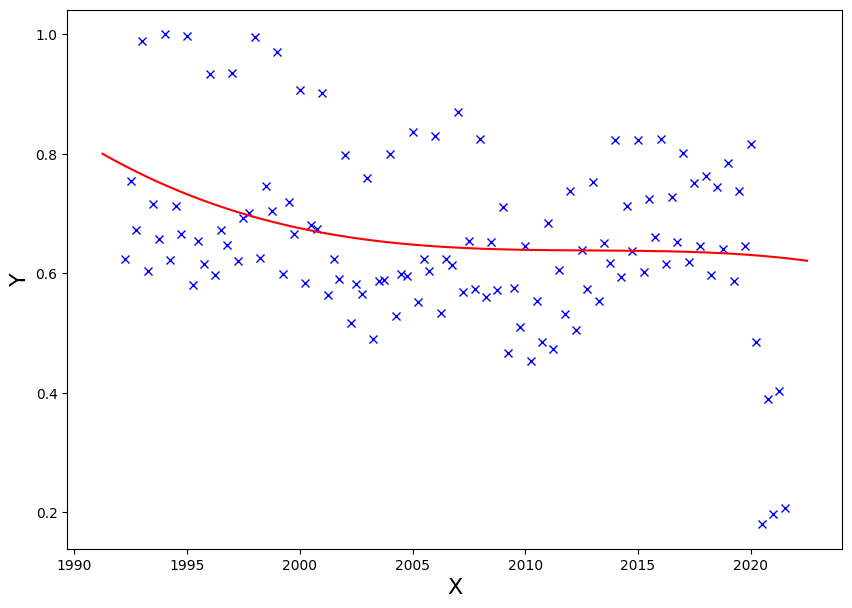

Women's clothing stores
Coefficients are:
[ 4.74499689e+04 -2.07924742e+01 -2.35127955e-03 -6.89811432e-06
  8.52440709e-10  1.97283680e-12 -4.10855558e-16  2.57491437e-19
  4.52019452e-23 -1.03627900e-25  1.63840794e-29]
For x = 2023.5, y is 0.6339849553587555 and the expected is 0.7574578469520103
For x = 2023.75, y is 0.6231810505596513 and the expected is 0.7064025468694729
MSE =  0.005542843102441436


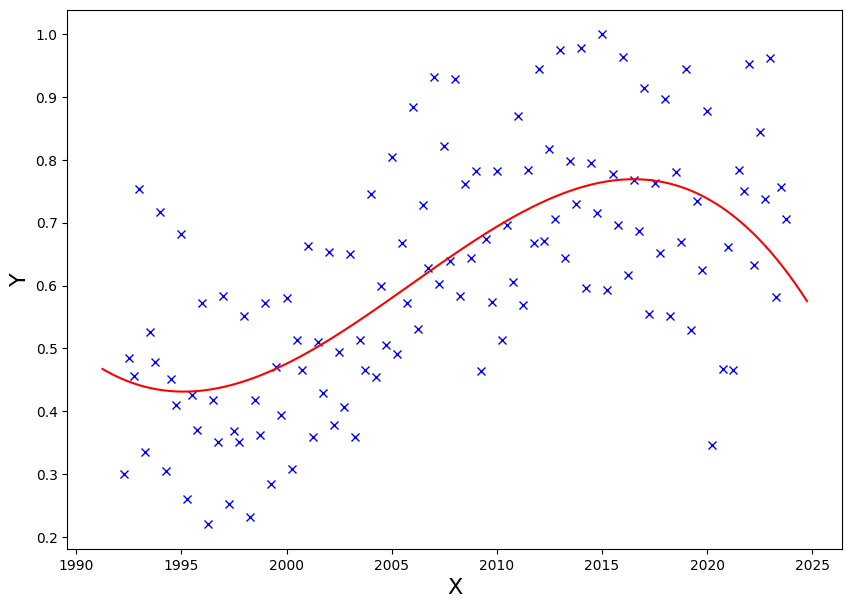

Family clothing stores
Coefficients are:
[ 1.88427354e+04 -1.71095066e+01  4.78440272e-03 -4.34320619e-06
  1.01957430e-09  1.50164241e-12 -5.06381173e-16  1.36085625e-19
 -2.84591909e-23 -7.14414624e-26  2.48748427e-29]
For x = 2023.5, y is 0.6964036054341705 and the expected is 0.7591088351286126
For x = 2023.75, y is 0.7008693290263182 and the expected is 0.7956030372594032
MSE =  0.0032266053264254284


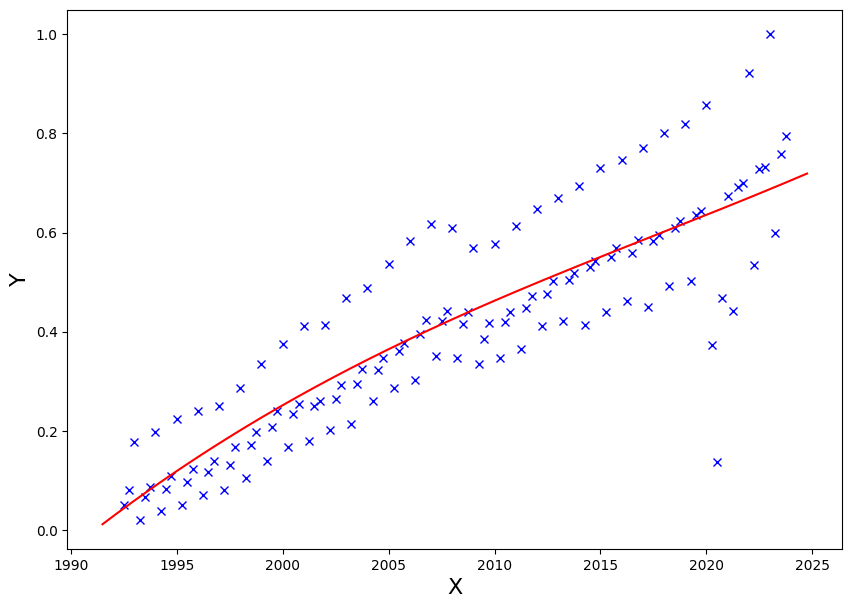

Other clothing stores
Coefficients are:
[-1.01316729e+05  8.28570945e+01 -4.16999479e-03  3.96602352e-05
 -2.50965897e-08 -1.60707720e-11  6.59579085e-15  2.26779313e-18
  6.67496515e-22 -9.49816832e-25  1.50224762e-28]
For x = 2023.5, y is 0.7907006054301746 and the expected is 0.9372881355932203
For x = 2023.75, y is 0.7861039081471972 and the expected is 0.9621468926553672
MSE =  0.013119759089928889


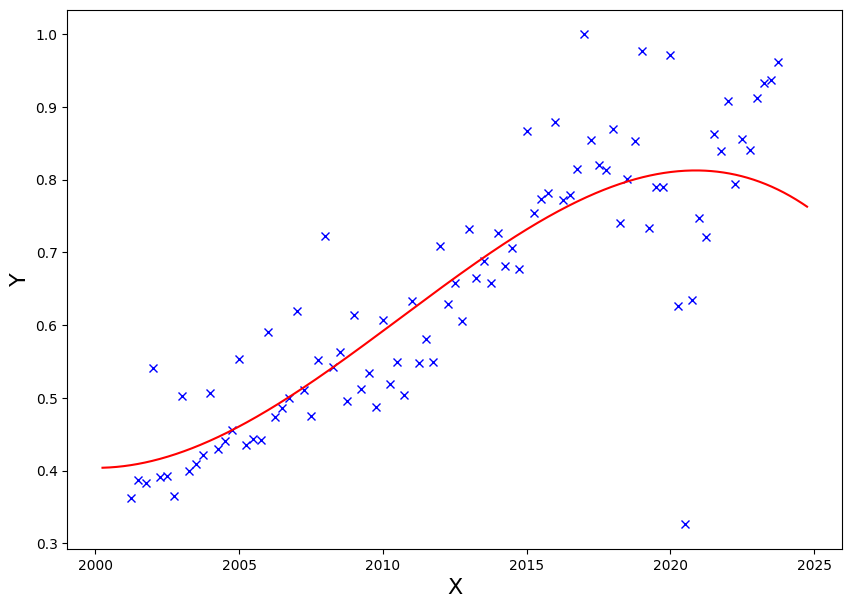

Shoe stores
Coefficients are:
[-7.34233961e+04  8.54925943e+01 -3.31393768e-02  1.29206373e-05
 -3.46890800e-09 -1.99939411e-12  9.37070529e-16 -5.33813175e-19
  3.95321911e-23  2.53928790e-25 -7.87716959e-29]
For x = 2023.5, y is 0.8456204070243984 and the expected is 0.7856644819411519
For x = 2023.75, y is 0.8510385361732915 and the expected is 0.9506345000697253
MSE =  0.0033785172464358706


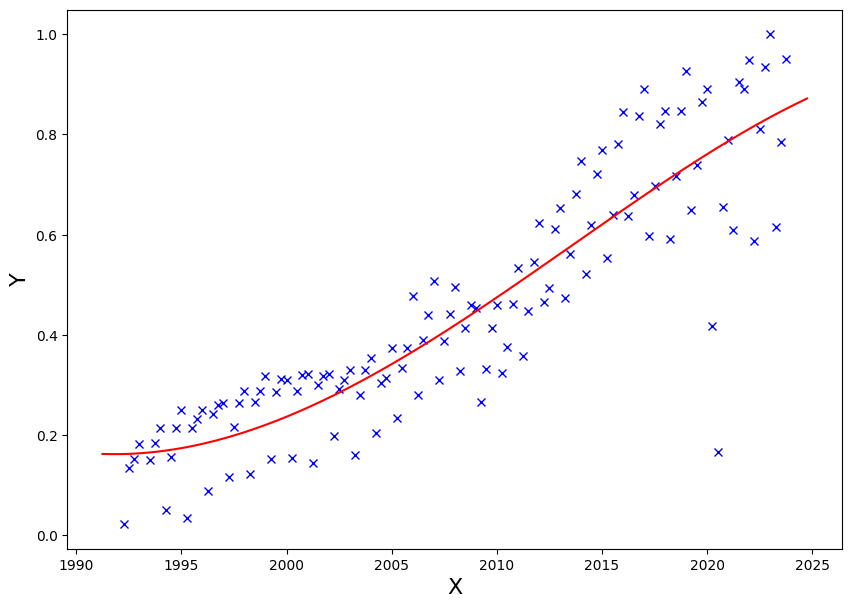

Jewelry stores
Coefficients are:
[-1.73497886e+03 -1.38668917e+00  8.17000181e-04  1.01261017e-06
 -2.10453348e-10 -1.05823362e-13  3.34277851e-17 -3.66401773e-20
 -4.39638280e-24  8.45053948e-27 -7.39356885e-31]
For x = 2021.0, y is 0.6019980794700359 and the expected is 1.0
For x = 2021.25, y is 0.6015234605299611 and the expected is 0.4151167392164622
MSE =  0.0482882486240985


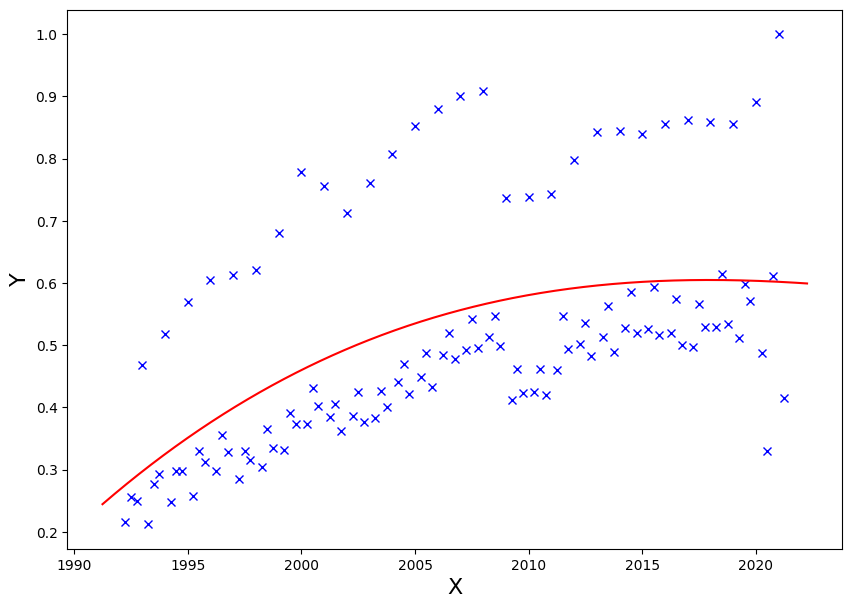

Sporting goods, hobby, musical instrument, and book stores
Coefficients are:
[ 3.18700312e+04 -4.09464482e+01  1.47768797e-02 -8.92814485e-06
  2.96971571e-09  3.29603134e-12 -1.30619275e-15  3.10393692e-19
 -1.33004097e-22 -1.63599357e-25  6.93655058e-29]
For x = 2023.5, y is 0.778436090942705 and the expected is 0.7615220987946112
For x = 2023.75, y is 0.7901319987577153 and the expected is 0.8103994327582131
MSE =  0.00017421300269011375


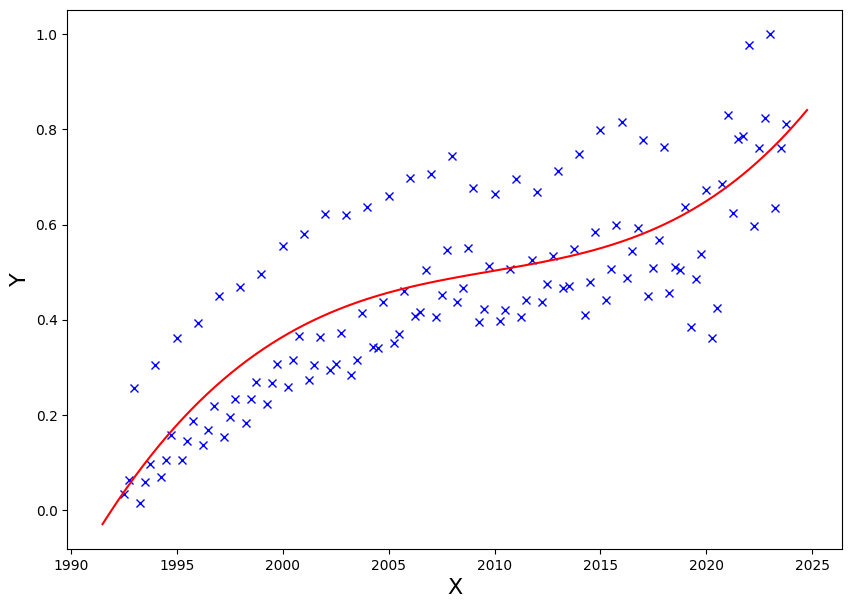

Sporting goods stores
Coefficients are:
[ 8.54053293e+04 -9.94435564e+01  3.85685590e-02 -1.50249398e-05
  4.04370810e-09  2.31991010e-12 -1.09107078e-15  6.19390960e-19
 -4.63519867e-23 -2.95089299e-25  9.17667322e-29]
For x = 2023.5, y is 0.8681978244712809 and the expected is 0.9052126200274349
For x = 2023.75, y is 0.8814098551374627 and the expected is 0.915843621399177
MSE =  0.0006389448383348332


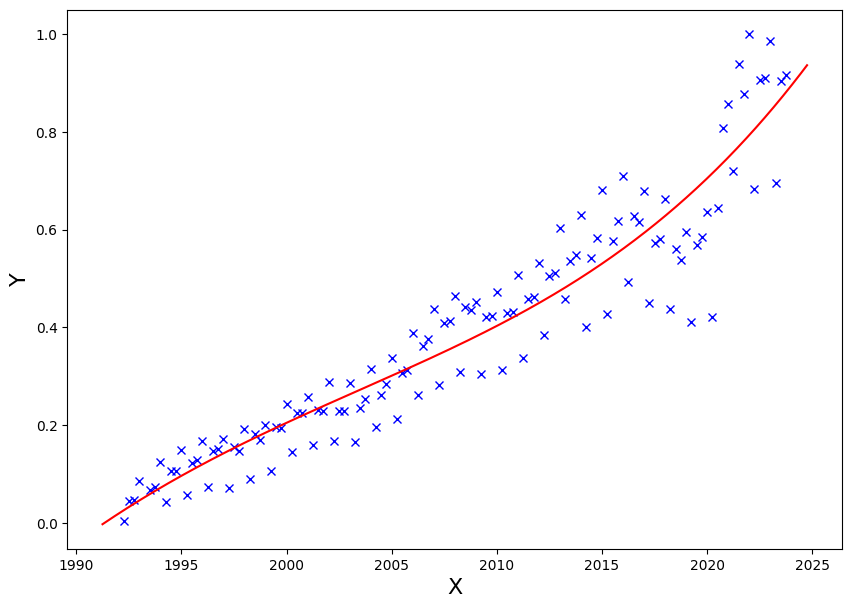

Hobby, toy, and game stores
Coefficients are:
[ 9.14739096e+02 -2.12035717e+01  1.15587252e-02 -2.89512416e-06
  2.16207654e-09  1.35645076e-12 -7.86598907e-16  1.42733885e-19
 -1.45227917e-22 -7.60435708e-26  4.74651237e-29]
For x = 2023.5, y is 0.6670833256648621 and the expected is 0.46796012815948734
For x = 2023.75, y is 0.6823914152919315 and the expected is 0.5306158775364899
MSE =  0.015671465412792178


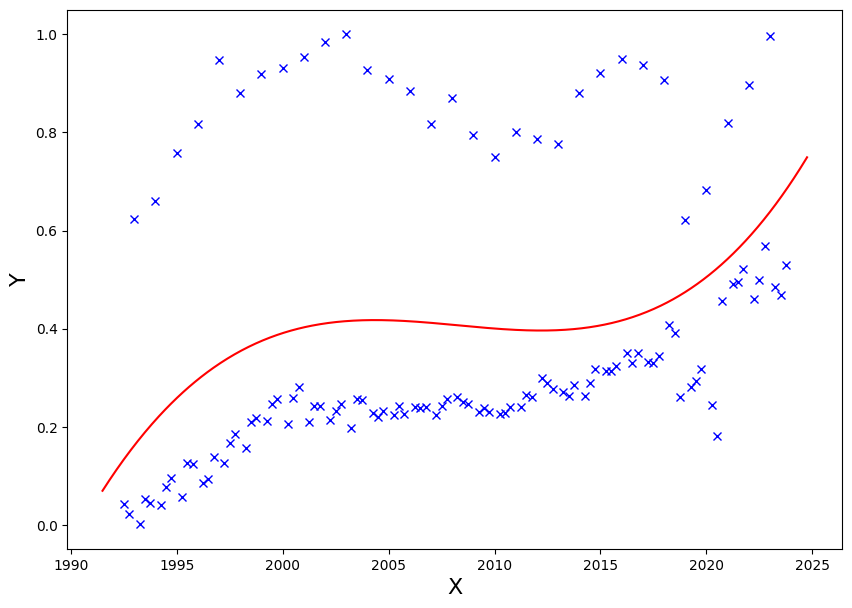

Book stores
Coefficients are:
[ 5.43634221e+04 -5.99391619e+01  1.24022105e-02 -7.51669629e-06
  3.74784547e-09  4.30867144e-12 -1.92453417e-15  6.08527031e-19
 -1.81094140e-22 -2.69869266e-25  1.05477730e-28]
For x = 2023.5, y is 0.21284519380424172 and the expected is 0.23391948172142527
For x = 2023.75, y is 0.20678409350512084 and the expected is 0.3216103655714947
MSE =  0.0034072995918159785


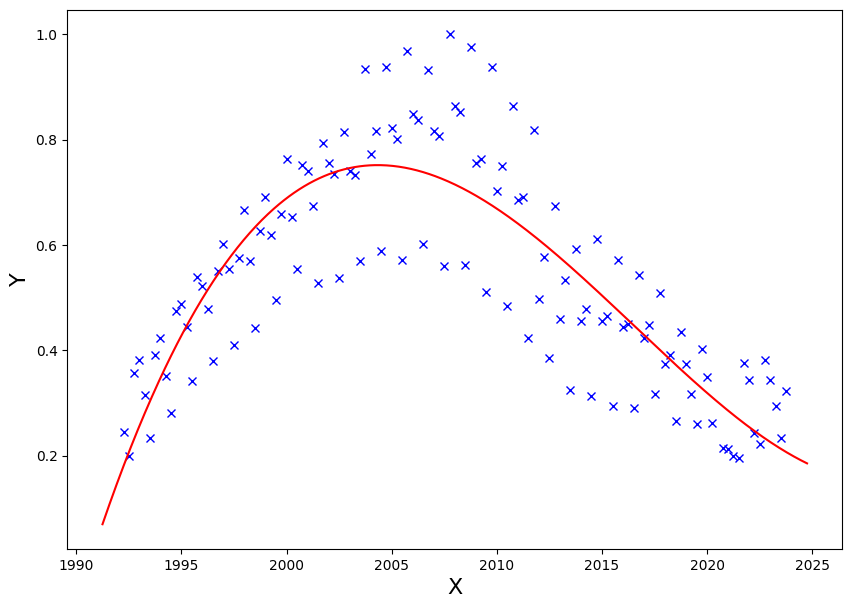

General merchandise stores
Coefficients are:
[ 2.72675122e+04 -2.50320280e+01  7.08367061e-03 -6.32017723e-06
  1.50381668e-09  2.18959813e-12 -7.43600550e-16  1.98680289e-19
 -4.32012843e-23 -1.04324967e-25  3.66490383e-29]
For x = 2023.5, y is 0.8233018990213168 and the expected is 0.8887267555180951
For x = 2023.75, y is 0.829788226285018 and the expected is 0.8907074751093084
MSE =  0.0019978916821378418


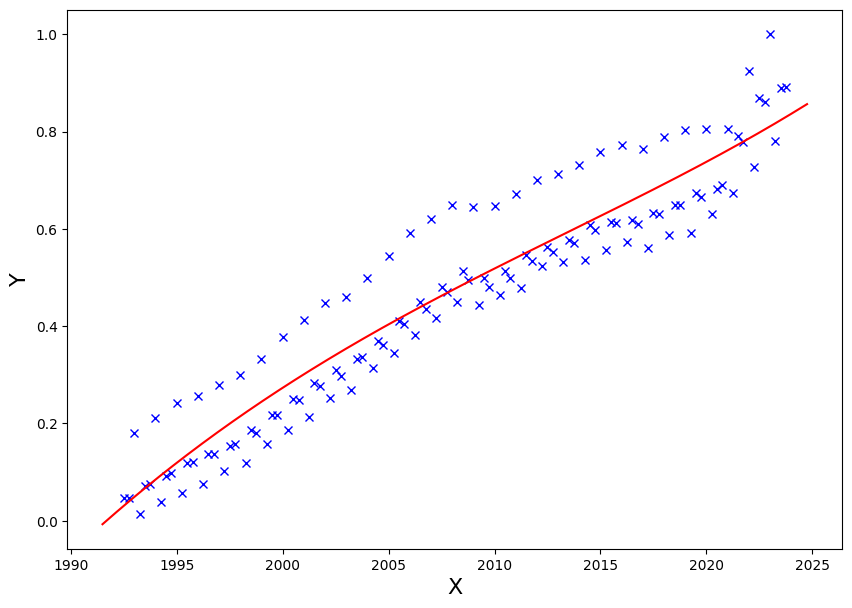

Department stores
Coefficients are:
[-2.20867420e+03 -1.85718407e+01  8.25573702e-03  5.36299805e-07
  1.46119773e-09  1.01617667e-12 -7.66280495e-16  1.57017468e-19
 -1.27877979e-22 -7.68760203e-26  4.60779530e-29]
For x = 2023.5, y is 0.19731022083578864 and the expected is 0.16144131751399476
For x = 2023.75, y is 0.19928339766920544 and the expected is 0.16793718117727977
MSE =  0.0005672908783444536


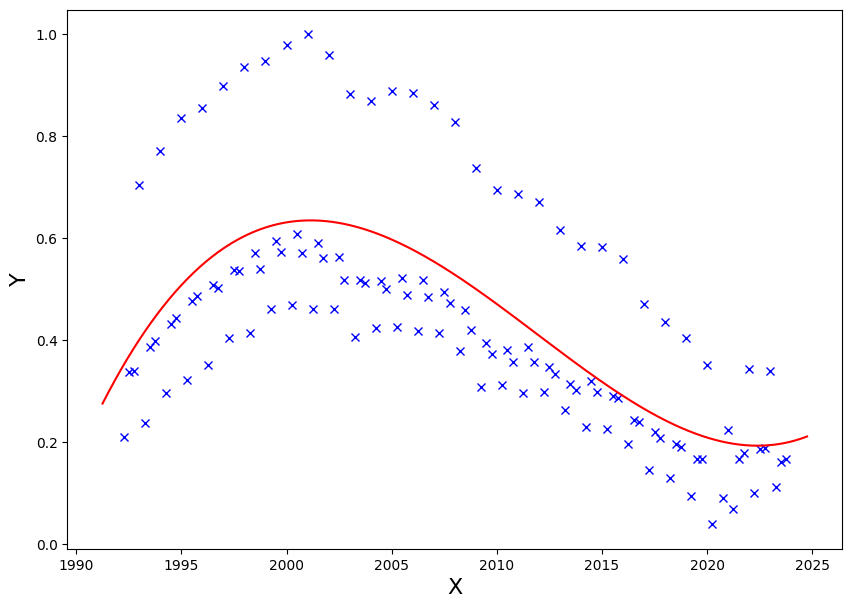

Department stores(excl. discount department stores)
Coefficients are:
[-1.69149384e+04  3.22636572e+00  2.55188345e-03  2.50207962e-06
  1.71770957e-11 -4.64220994e-13 -1.88065124e-17 -5.56134597e-20
 -4.26294854e-23  1.94075351e-26  4.02106831e-30]
For x = 2023.5, y is 0.16401978077647072 and the expected is 0.15454218795936367
For x = 2023.75, y is 0.16038992869562207 and the expected is 0.1337667004213896
MSE =  0.00019965526238131006


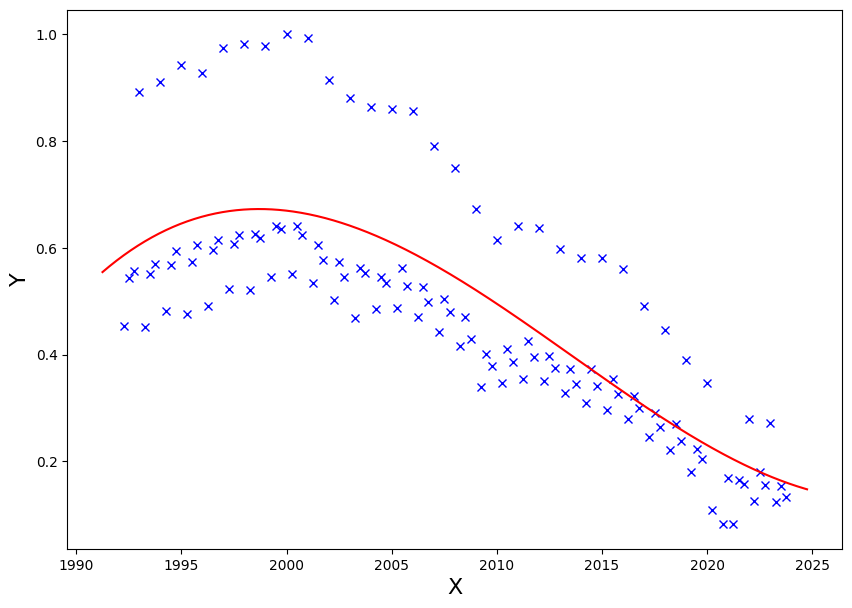

Discount dept. stores
Coefficients are:
[ 1.64940465e+04 -4.38987458e+01  2.02292455e-02 -7.62685878e-06
  3.88934068e-09  3.14244245e-12 -1.52190739e-15  3.13414004e-19
 -2.28534497e-22 -1.65873673e-25  8.72378601e-29]
For x = 2023.5, y is 0.30907122358621564 and the expected is 0.2612946998722861
For x = 2023.75, y is 0.31660775853379164 and the expected is 0.30024744572158363
MSE =  0.0006375640126204839


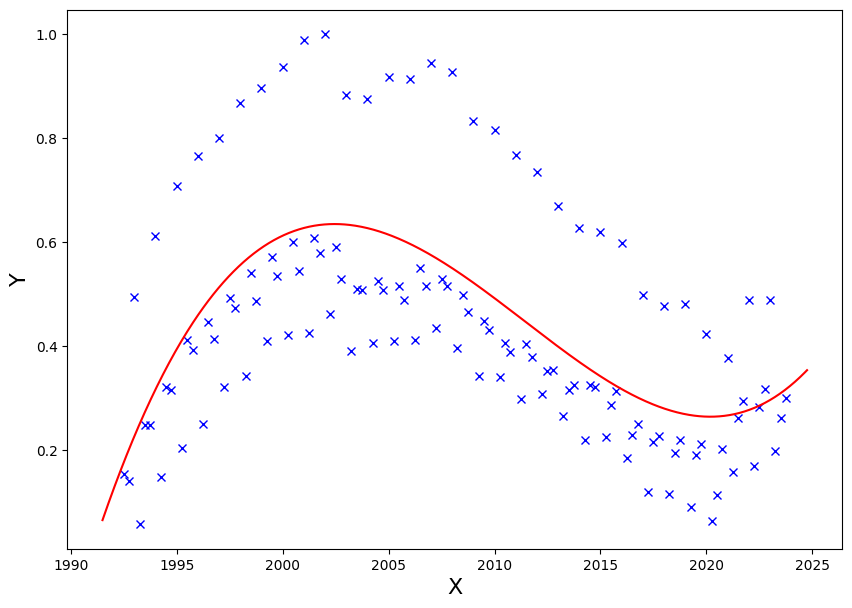

Other general merchandise stores
Coefficients are:
[ 2.77495157e+04 -1.99449361e+01  4.14666089e-03 -5.70016641e-06
  9.57446489e-10  1.87845821e-12 -5.50853587e-16  1.65008820e-19
 -5.08290894e-24 -8.63949329e-26  2.47991524e-29]
For x = 2023.5, y is 0.8627564031557995 and the expected is 0.9354673103915325
For x = 2023.75, y is 0.8692504105129046 and the expected is 0.9356639231899334
MSE =  0.0024244076742634


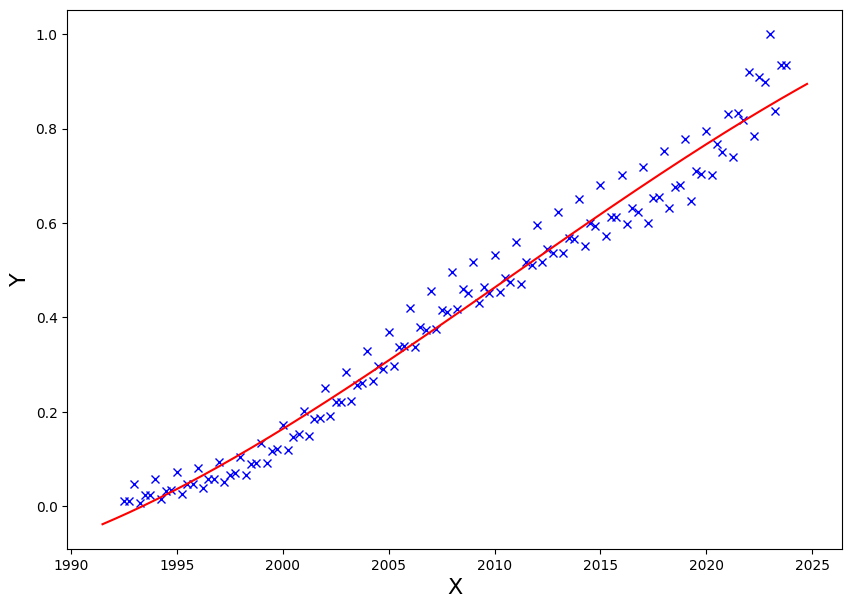

Warehouse clubs and superstores
Coefficients are:
[ 3.02328986e+04 -2.15803809e+01  4.42814807e-03 -6.19187206e-06
  1.02749140e-09  2.03781783e-12 -5.94065423e-16  1.78872593e-19
 -4.40351715e-24 -9.36283483e-26  2.66502929e-29]
For x = 2023.5, y is 0.8580034086262458 and the expected is 0.9352091565608394
For x = 2023.75, y is 0.8632775684891385 and the expected is 0.9423751068389302
MSE =  0.003054287022215825


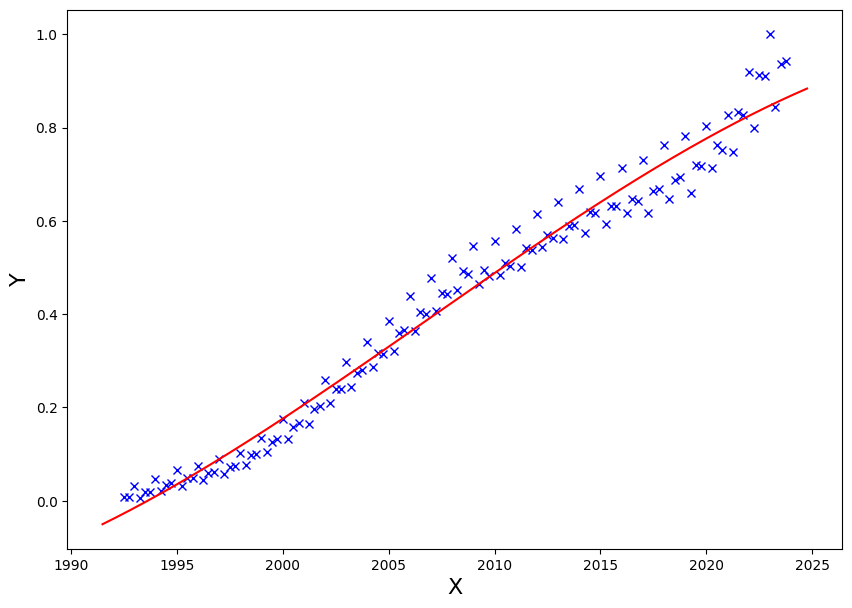

All other gen. merchandise stores
Coefficients are:
[ 6.47047615e+03 -6.49250860e+00  3.16729859e-03 -2.49232076e-06
  4.93832835e-10  5.82685099e-13 -2.32441756e-16  7.26655456e-20
  3.47220272e-25 -3.68298075e-26  1.13084096e-29]
For x = 2023.5, y is 0.9020623430897103 and the expected is 0.9386405832540868
For x = 2023.75, y is 0.9175396267892211 and the expected is 0.8878775528687225
MSE =  0.0005544515706668593


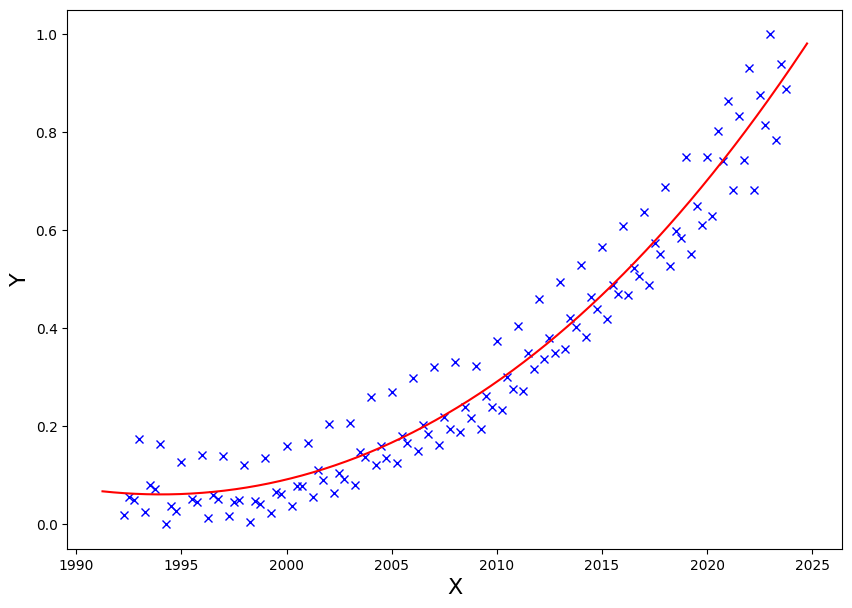

Miscellaneous store retailers
Coefficients are:
[ 1.83554728e+04 -4.41139431e+01  1.99538548e-02 -7.84872705e-06
  3.83867145e-09  3.19071269e-12 -1.52219125e-15  3.15995006e-19
 -2.21793295e-22 -1.67312102e-25  8.66615195e-29]
For x = 2023.5, y is 0.9046056672523264 and the expected is 1.0
For x = 2023.75, y is 0.9294509500905406 and the expected is 0.9398037019256414
MSE =  0.0023018145466544735


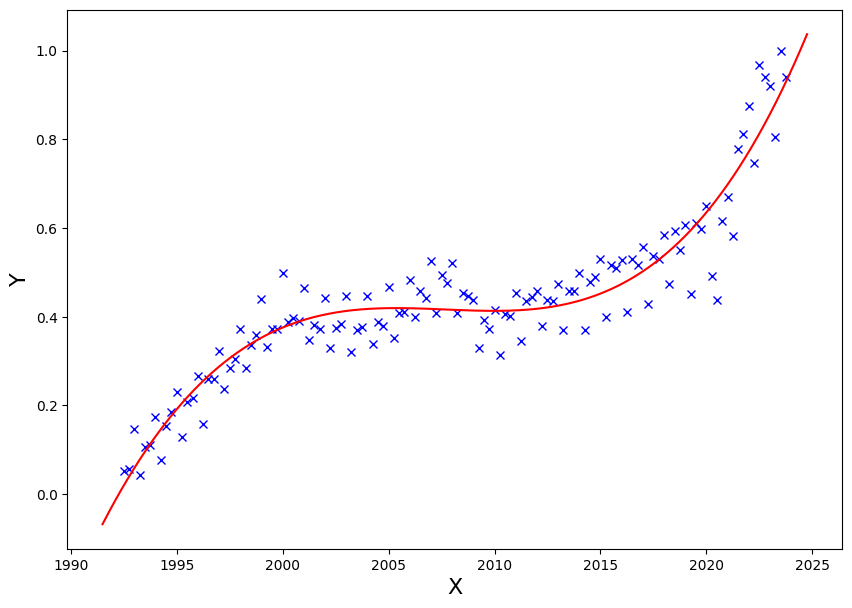

Office supplies, stationery, and gift stores
Coefficients are:
[ 1.54476432e+04 -4.48447267e+01  1.51499964e-02 -1.83036630e-06
  3.20086795e-09  2.80032573e-12 -1.66733008e-15  4.13769837e-19
 -2.30869148e-22 -1.92980116e-25  9.67929909e-29]
For x = 2023.5, y is 0.47967960068490356 and the expected is 0.4042284269792026
For x = 2023.75, y is 0.4893566228856798 and the expected is 0.5069516258761346
MSE =  0.0015006159357400146


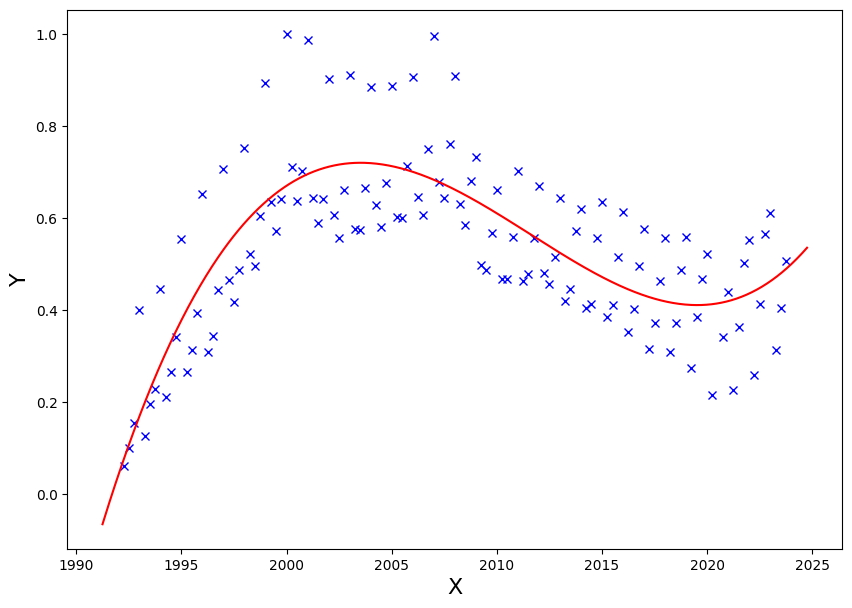

Office supplies and stationery stores
Coefficients are:
[ 3.81682915e+04 -6.97701977e+01  1.97229027e-02 -2.39348309e-06
  3.37131093e-09  4.65275245e-12 -2.36500292e-15  3.61804078e-19
 -2.26784690e-22 -2.11848647e-25  1.07785864e-28]
For x = 2023.5, y is 0.048921545370831154 and the expected is 0.05644171779141104
For x = 2023.75, y is 0.04476143039937597 and the expected is 0.14429447852760735
MSE =  0.0024908451664025005


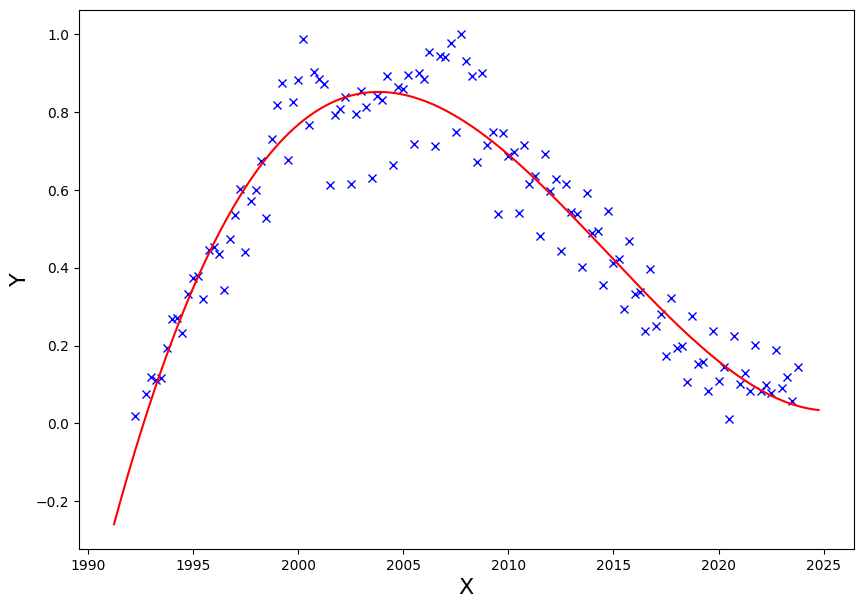

Gift, novelty, and souvenir stores
Coefficients are:
[-5.06579657e+03 -2.34600705e+01  1.10165148e-02  1.02519142e-06
  1.88244067e-09  1.24230099e-12 -9.93991935e-16  1.94661241e-19
 -1.70930848e-22 -9.62450138e-26  6.01374882e-29]
For x = 2023.5, y is 0.7741086479509249 and the expected is 0.6469788226151156
For x = 2023.75, y is 0.7935347472375724 and the expected is 0.7511171556246357
MSE =  0.004490311142655626


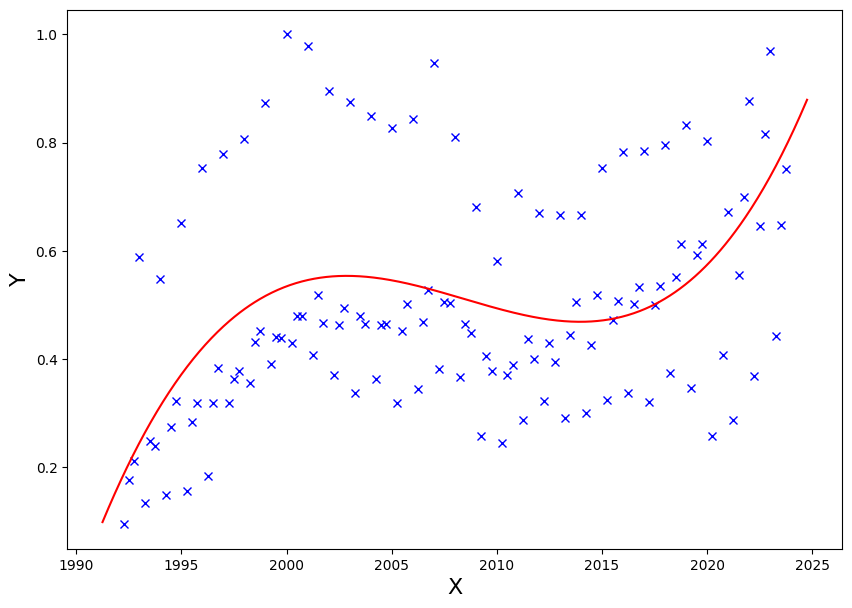

Used merchandise stores
Coefficients are:
[ 2.87271251e+03 -1.28177852e+01  6.43216621e-03 -1.99609101e-06
  1.21596640e-09  8.67829319e-13 -4.61286953e-16  8.81594394e-20
 -7.68582810e-23 -4.70336654e-26  2.71211119e-29]
For x = 2023.5, y is 0.9035174903874577 and the expected is 1.0
For x = 2023.75, y is 0.9219584981510707 and the expected is 0.9479574706211528
MSE =  0.0024962053080096044


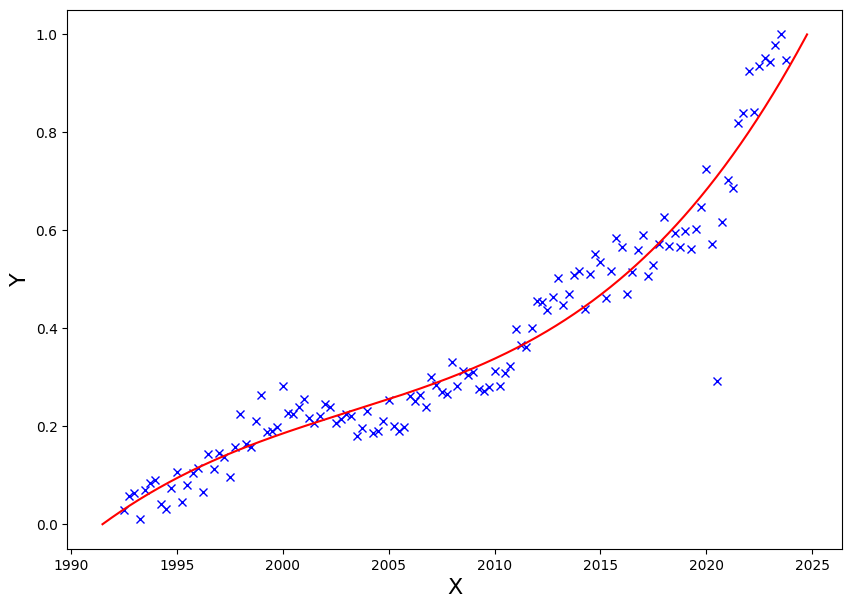

Nonstore retailers
Coefficients are:
[ 4.15902948e+04 -5.24860046e+01  1.12481867e-02 -2.96393424e-06
  2.19643360e-09  3.64395734e-12 -1.65897602e-15  3.16809405e-19
 -1.38211582e-22 -1.66432629e-25  7.47748911e-29]
For x = 2023.5, y is 0.9237757987430086 and the expected is 0.9103472047224709
For x = 2023.75, y is 0.9523499553615693 and the expected is 0.9175276544347025
MSE =  0.0003482299449978341


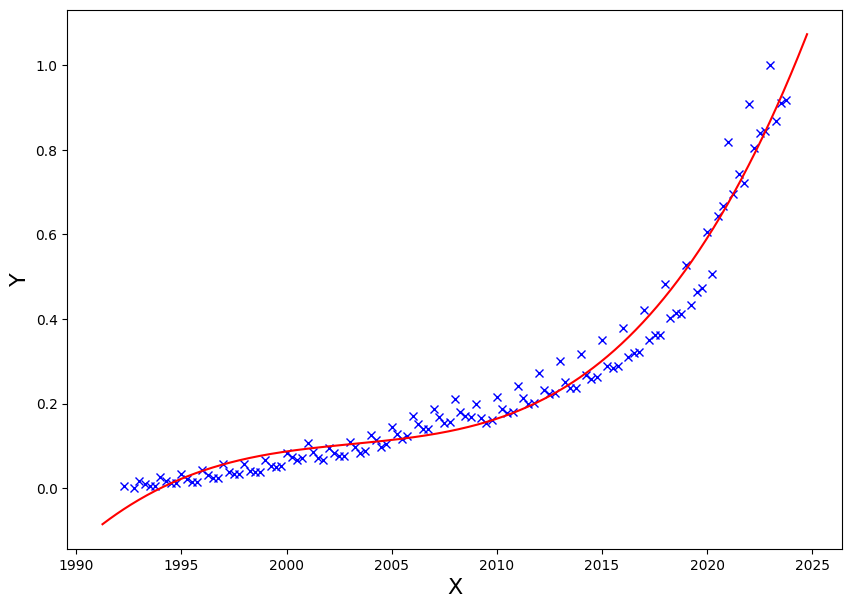

Electronic shopping and mail-order houses
Coefficients are:
[ 3.17541226e+04 -4.49135225e+01  1.71017384e-02 -9.42600805e-06
  3.38703357e-09  3.53558649e-12 -1.46204190e-15  3.35785102e-19
 -1.62596942e-22 -1.77278247e-25  7.88322950e-29]
For x = 2023.5, y is 0.9350240420026239 and the expected is 0.9186813186813186
For x = 2023.75, y is 0.9646030848962255 and the expected is 0.928723536350655
MSE =  0.00038860665222876264


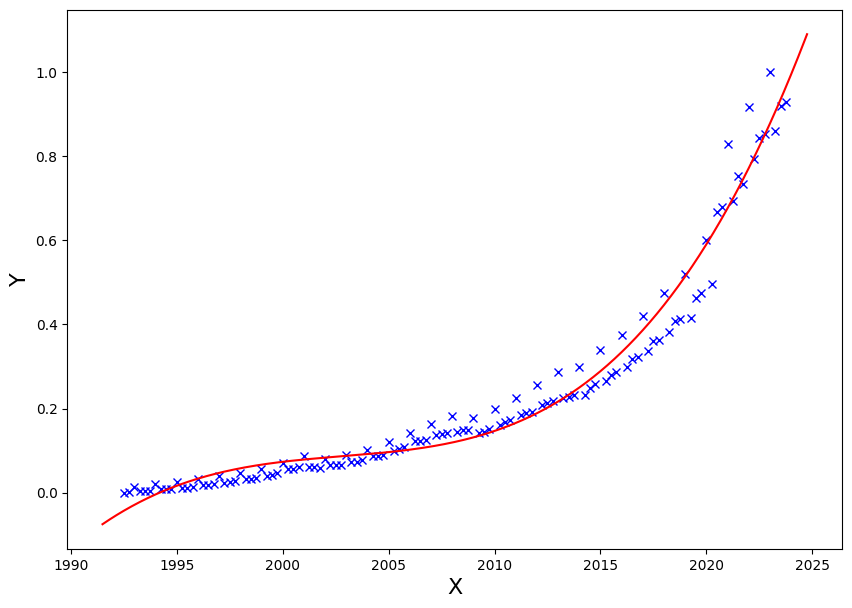

Fuel dealers
Coefficients are:
[ 6.12337887e+05 -5.34524529e+02  3.99526000e-02  3.38314933e-06
  4.74503660e-09  2.01425143e-11 -7.08504096e-15  3.23144855e-18
 -8.57677729e-22 -1.24261879e-24  4.34529578e-28]
For x = 2023.5, y is 0.4060109205893241 and the expected is 0.31998310691912435
For x = 2023.75, y is 0.4050529843661934 and the expected is 0.27113394805377633
MSE =  0.006333773258221648


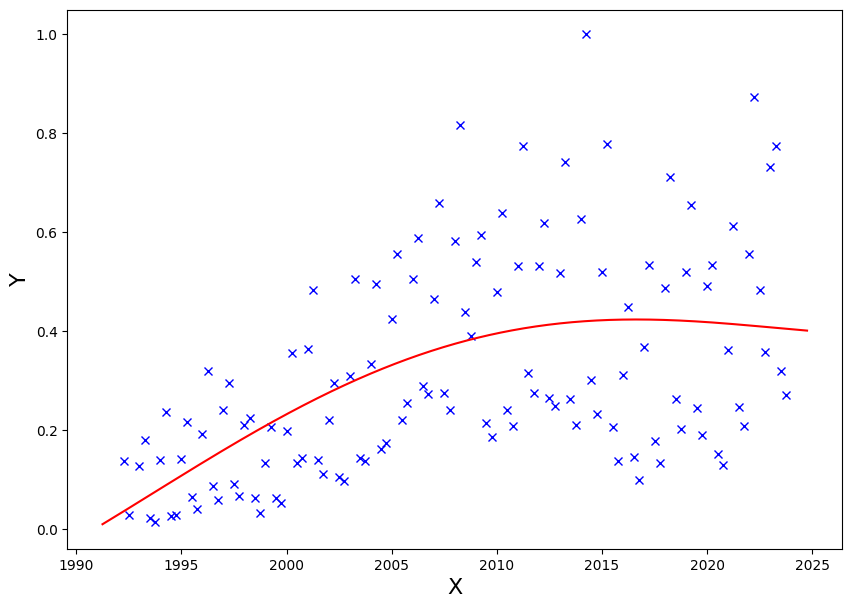

Food services and drinking places
Coefficients are:
[ 1.45198220e+04 -1.75560142e+01  6.15718925e-03 -3.91588797e-06
  1.23985962e-09  1.42870393e-12 -5.56718432e-16  1.33532315e-19
 -5.32732734e-23 -7.04288989e-26  2.92673708e-29]
For x = 2023.5, y is 0.8116641708402312 and the expected is 0.9896027009573837
For x = 2023.75, y is 0.8265568612914649 and the expected is 1.0
MSE =  0.015436160716322053


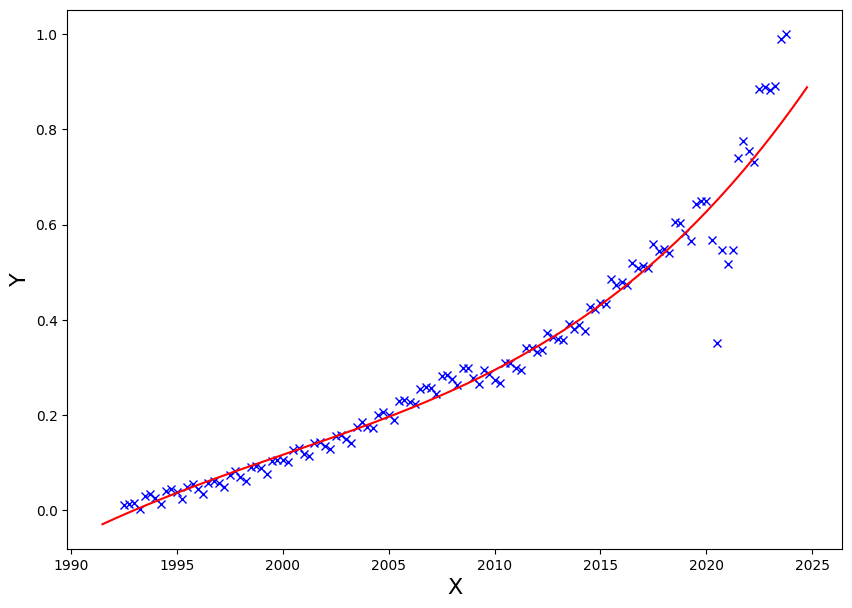

Drinking places
Coefficients are:
[-1.51116075e+03  1.49661233e+01 -6.96881681e-03 -6.39996806e-06
  1.90852195e-09  1.80034231e-12 -5.76173967e-17 -3.49593530e-19
 -1.22527144e-22  1.31918666e-25 -2.46413363e-29]
For x = 2018.0, y is 0.9063566905460902 and the expected is 1.0
For x = 2018.25, y is 0.909447614394594 and the expected is 0.6226038951081122
MSE =  0.02276209717463478


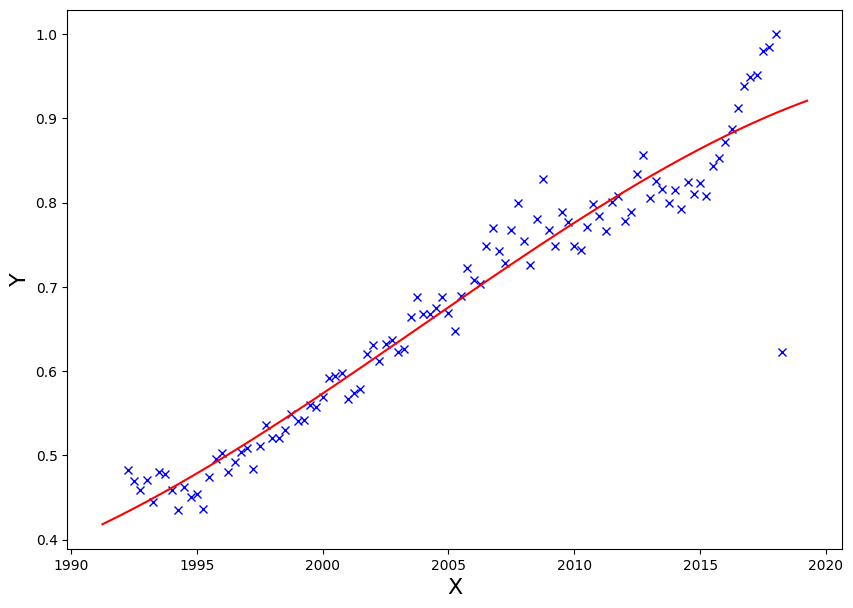

Restaurants and other eating places
Coefficients are:
[ 1.55345396e+04 -1.97191927e+01  7.11022715e-03 -4.31281252e-06
  1.42359460e-09  1.58740731e-12 -6.30797312e-16  1.49110621e-19
 -6.36285935e-23 -7.86803685e-26  3.34464293e-29]
For x = 2023.5, y is 0.8298529798339587 and the expected is 0.9922378519720118
For x = 2023.75, y is 0.846217005768267 and the expected is 1.0
MSE =  0.012504514003014104


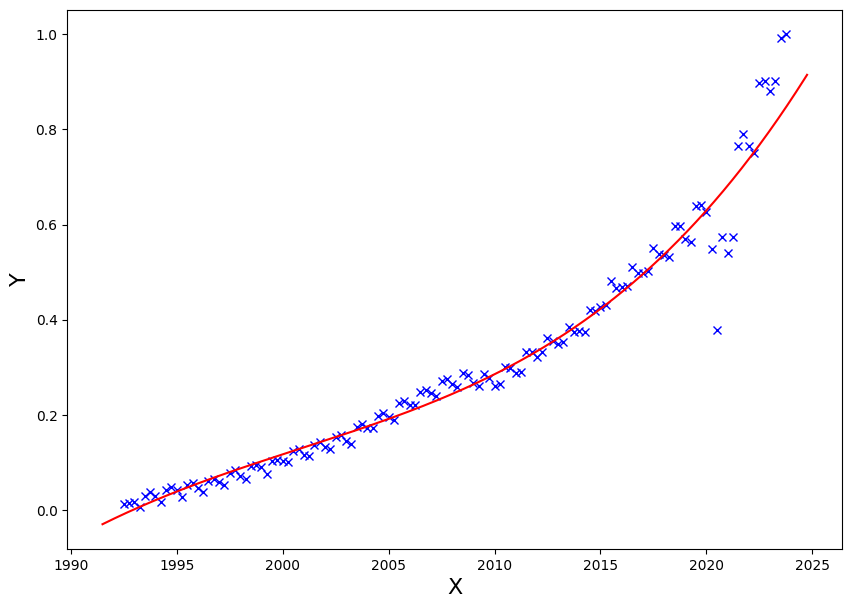

Full service restaurants
Coefficients are:
[-5.79481780e+01 -3.37875135e+00  9.96904179e-04 -5.68296058e-07
  8.54955609e-10  1.80228872e-13 -2.27221422e-16  1.57337222e-19
 -2.53070637e-23 -7.60082168e-26  2.70759686e-29]
For x = 2020.0, y is 0.9919658972539764 and the expected is 1.0
For x = 2020.25, y is 1.0057345990135218 and the expected is 0.3238885264237114
MSE =  0.11624465337701578


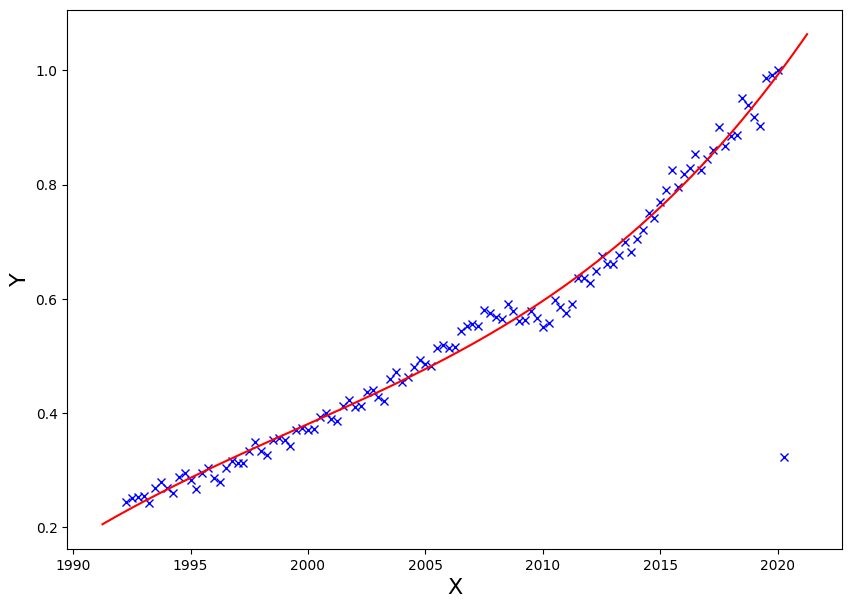

Limited service eating places
Coefficients are:
[ 1.56673343e+04 -2.03334540e+01  7.42547486e-03 -4.40823673e-06
  1.48195815e-09  1.62866065e-12 -6.53332185e-16  1.53337406e-19
 -6.73831437e-23 -8.09218579e-26  3.47689040e-29]
For x = 2023.5, y is 0.8510435934877023 and the expected is 0.9952533278299454
For x = 2023.75, y is 0.8686934282304719 and the expected is 1.0
MSE =  0.009509465815943528


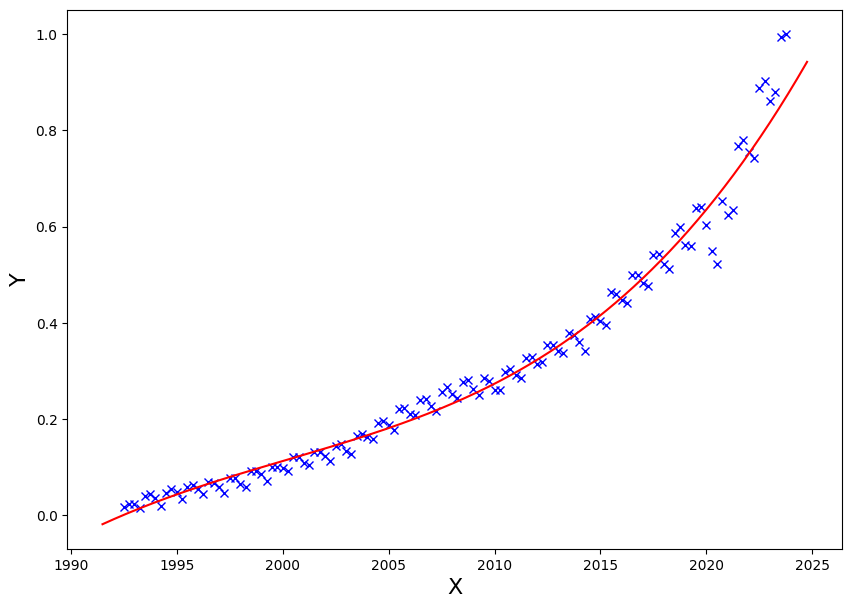

GDP
Coefficients are:
[ 4.47369976e+02 -4.63422553e-01  1.20003309e-04]
For x = 2023.5, y is 0.9942579363561208 and the expected is 0.9868982119563653
For x = 2023.75, y is 0.9998231459355225 and the expected is 1.0
MSE =  1.3549205150195106e-05


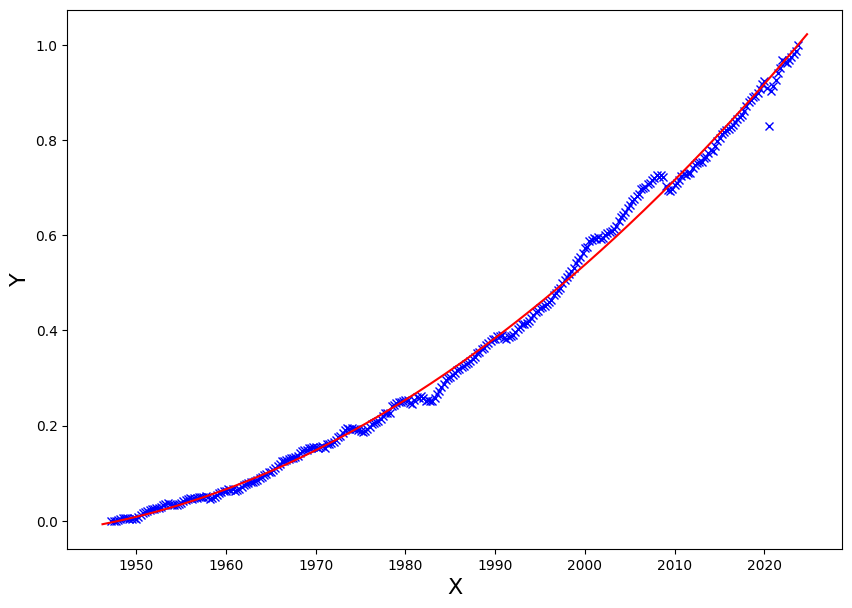

Zillow
Coefficients are:
[-1.78139916e+05  8.09698173e+00 -2.79866974e-02  2.75967002e-05
  1.67518327e-08 -2.79095821e-12  1.58323219e-15  1.54879832e-19
 -1.59614816e-22 -2.96572635e-25  1.10710097e-28  7.00280171e-32
 -9.67477204e-35 -1.23448908e-38  9.99841981e-42 -9.99205384e-45
 -2.79448231e-49  1.69934184e-51  2.72608792e-55  1.93267577e-58
 -6.01967138e-63  2.99035564e-65 -3.50798682e-68  2.43255846e-71
 -1.12968663e-77 -4.17712986e-78]
For x = 2023.75, y is 1.1002242624526843 and the expected is 1.0
For x = 2024.0, y is 1.1441626248124521 and the expected is 0.0
MSE =  0.329788253714209


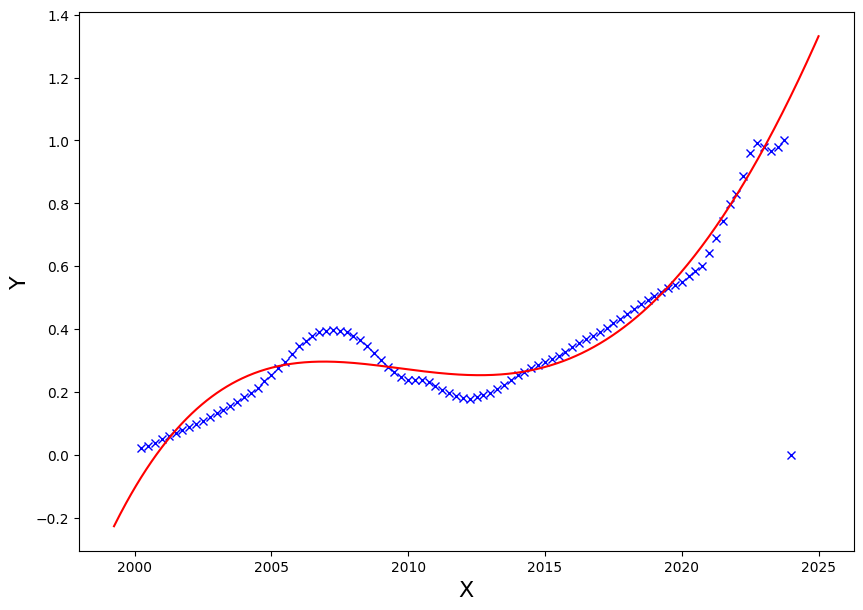

Coffee
Coefficients are:
[-3.07318092e+06  1.87713968e+03  9.83616772e-01 -5.22414218e-04
  4.17546392e-08 -8.43817401e-11 -3.91956027e-14  2.40182631e-17
  1.38977769e-20 -4.08047299e-24 -4.28279155e-28]
For x = 2023.5, y is 0.5574947886634618 and the expected is 0.6370280720941787
For x = 2023.75, y is 0.5431816772907041 and the expected is 0.6503257451054958
MSE =  0.004451348663111972


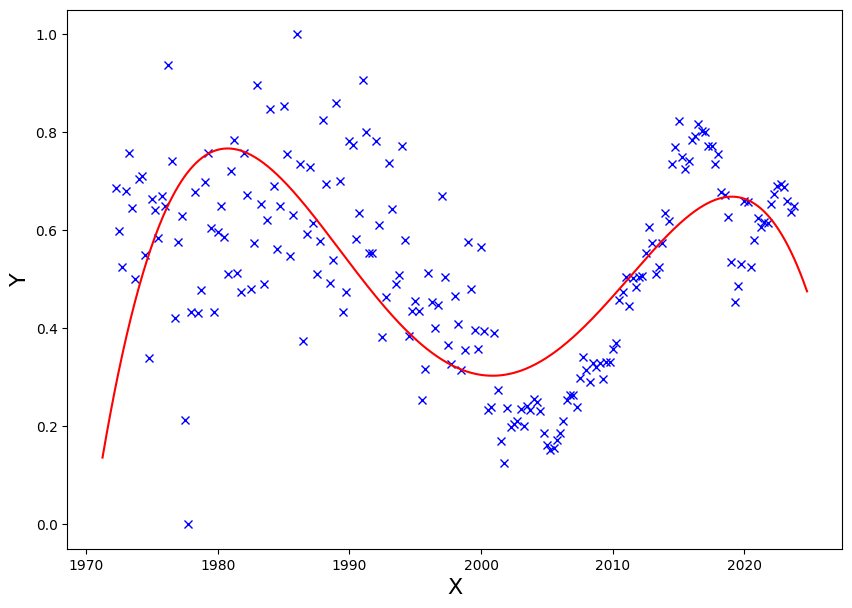

In [259]:
### Polynomial Regression

def GenReg(fullX,fullY,trainX,trainY,testX,testY,degree):
    trainX=np.vstack([np.ones(len(trainX)),trainX])
    for i in range(degree-1):
        trainX=np.vstack([trainX,np.power(trainX[1,:],i+2)])
    theta=(np.linalg.solve(np.matmul(trainX,trainX.T),np.matmul(trainX,trainY)))
    print("Coefficients are:")
    print(theta)
    
    newTrainX=np.zeros(shape=(degree+1,700))
    i = 0
    for row in trainX:
        row=np.linspace(np.min(row),np.max(row),700)
        if i == 1:
            row = np.linspace(np.min(fullX)-1,np.max(fullX)+1,700)
        if(i>1):
            row = np.power(newTrainX[1],i)
        newTrainX[i] = row
        i+=1
    
    # Testing on points
    test = np.zeros(shape=(len(testX),degree+1))
    for i in range(degree+1):
        for j in range(len(testX)):
            test[j][i]=pow(testX[j],i)

    for i in range(len(testX)):
        print("For x = "+str(testX[i])+", y is "+str(np.matmul(test[i],theta))+" and the expected is "+str(testY[i]))
    
    print("MSE = ",np.linalg.norm(np.matmul(test,theta) - testY)**2/pow(len(testY),2))

    Y_pred = np.matmul(newTrainX.T,theta)  # calculating the regression line

    fig, ax = plt.subplots()  # ax refers to the picture, fig refers to an invisible container around it
    fig.set_size_inches(10, 7) 

    ax.set_xlabel("X", fontsize=16)
    ax.set_ylabel("Y", fontsize=16)

    ax.plot(fullX,fullY,'x',color='Blue')  # scatter plot of data
    plt.plot(newTrainX.T[:,1],Y_pred, color='red') # regression line

    plt.show()


# Census
n = 0
for row in census_y:
    print(census_names[n])
    temp_x = census_x_interval
    temp_y = row
    i = 0
    for num in temp_y:
        if num == 0:
            temp_x = np.delete(temp_x,i)
            temp_y = np.delete(temp_y,i)
        else:
            i+=1

    GenReg(temp_x,temp_y,temp_x[0:len(temp_x)-3],temp_y[0:len(temp_y)-3],temp_x[len(temp_x)-2:], temp_y[len(temp_y)-2:],10)
    n+=1

# GDP
print("GDP")
GenReg(GDP_x_interval,GDP_y,GDP_x_interval[0:len(GDP_x_interval)-3],GDP_y[0:len(GDP_y)-3],GDP_x_interval[len(GDP_x_interval)-2:], GDP_y[len(GDP_y)-2:],2)

# Zillow
print("Zillow")
GenReg(Zillow_x_interval,Zillow_y,Zillow_x_interval[0:len(Zillow_x_interval)-3],Zillow_y[0:len(Zillow_y)-3],Zillow_x_interval[len(Zillow_x_interval)-2:], Zillow_y[len(Zillow_y)-2:],25)

# Coffee 
print("Coffee")
GenReg(Coffee_x_interval,Coffee_y,Coffee_x_interval[0:len(Coffee_x_interval)-3],Coffee_y[0:len(Coffee_y)-3],Coffee_x_interval[len(Coffee_x_interval)-2:], Coffee_y[len(Coffee_y)-2:],10)


### Ridge Regression

In [ ]:
 def ridge_regression(x,y,alpha=1.0, test_size=0.2, random_state=42):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    if len(X_train) == 0:
        raise ValueError("The resulting train set is empty. Adjust test_size or provide more data.")


    # Initialize and train the Ridge regression model
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train_scaled, y_train)

    # Make predictions on the test set
    y_pred = ridge_model.predict(X_test_scaled)

    # Evaluate the model
    mse = mean_squared_error(y_test, y_pred)
    print(f'Mean Squared Error: {mse}')
    
    # Plot predicted vs actual values
    plt.scatter(y_test, y_pred)
    plt.xlabel("Actual Values")
    plt.ylabel("Predicted Values")
    plt.title("Ridge Regression: Actual vs Predicted")
    plt.show()